<b>Heston Calibration Neural Network Approach</b>
<br>
<br>
<i>Plot function implementation from: https://github.com/svenhsia/Calibrating-Rough-Volatility-Models-with-Deep-Learning/tree/master </i>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from rbergomi.rbergomi import rBergomi
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import helpers
from scipy.stats import truncnorm

import seaborn as sns

from tqdm import tqdm
tqdm.pandas()



import QuantLib as ql

from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException
import sklearn.utils
import logging

import gc

from scipy.signal import savgol_filter

logging.basicConfig(format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO)

import tensorflow as tf
import keras as K
from keras.callbacks import EarlyStopping
import tensorflow.experimental.numpy as tnp

%matplotlib inline

In [5]:
dat = pd.read_csv('data/heston_data.csv')
dat.dropna(inplace=True)

In [6]:
dat.shape

(1048276, 8)

In [7]:
dat.head()

Moneyness  Time to Maturity (years)     kappa     theta     sigma  \
0   1.056539                  0.059524  2.357834  0.169200  0.426679   
1   1.132845                  0.416508  5.142975  0.211083  0.728213   
2   0.967320                  0.115079  3.206538  0.282006  3.078118   
3   0.990799                  0.055556  7.840063  0.374285  4.438052   
4   0.954407                  0.087302  1.717184  0.046202  3.900461   

        rho        v0        iv  
0 -0.371929  0.586372  0.747496  
1 -0.912404  0.538233  0.549009  
2 -0.073572  0.210078  0.418916  
3 -0.737083  0.885006  0.835736  
4 -0.838174  0.200892  0.404385

In [8]:
#only used for input data, output is not rescaled 

class FeatureScaler(object):
    def __init__(self, train):
        self.mean = train.mean(axis=0)
        self.std = train.std(axis=0)
    
    def transform(self, df):
        return (df - self.mean) / self.std
    
    def inverse_transform(self, df):
        return df * self.std + self.mean
    
    def get_params(self):
        return self.mean, self.std

In [9]:
from tensorflow.keras import layers
#elu activation function
def build_nn(input_length, hidden_layer_sizes=[30, 30, 30]):
    model = tf.keras.Sequential()
    model.add(layers.Dense(units=hidden_layer_sizes[0], activation='elu', kernel_initializer='random_normal', 
                           input_shape=(input_length,)))
    for layer_idx in range(1, np.array(hidden_layer_sizes).size):
        model.add(layers.Dense(units=hidden_layer_sizes[layer_idx], activation='elu', kernel_initializer='random_normal'))
    #fully connected layer with linear activation at the end
    model.add(layers.Dense(units=1, activation='linear', kernel_initializer='random_normal'))
    return model


In [10]:
#random shuffle
dat = dat.sample(frac=1).reset_index(drop=True)
#split into train, val, test
train = dat.iloc[:int(dat.shape[0]*0.8), :]
val = dat.iloc[int(dat.shape[0]*0.8):int(dat.shape[0]*0.9), :]
test = dat.iloc[int(dat.shape[0]*0.9):, :]

In [11]:
train.shape, val.shape, test.shape

((838620, 8), (104828, 8), (104828, 8))

In [12]:
#scale the data
X_train_origin, Y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_val_origin, Y_val = val.iloc[:, :-1], val.iloc[:, [-1]]
X_test_origin, Y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

In [13]:
SCALER = FeatureScaler(X_train_origin)
X_train = SCALER.transform(X_train_origin)
X_val = SCALER.transform(X_val_origin)
X_test = SCALER.transform(X_test_origin)

In [14]:
X_train.shape, Y_train.shape

((838620, 7), (838620, 1))

In [15]:
X_test.shape, Y_test.shape

((104828, 7), (104828, 1))

In [16]:
import keras
from keras.layers import Activation
from keras import backend as K
from tensorflow.keras.saving import get_custom_objects


keras.backend.set_floatx('float64')
inflow = keras.layers.Input(shape=(7,))
x1 = keras.layers.Dense(30,activation = 'elu')(inflow)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 


x3=keras.layers.Dense(1,activation = 'linear')(x2)

model = keras.models.Model(inputs=inflow, outputs=x3)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 30)                240       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________


In [17]:
def mse(y_true, y_pred):
        return K.mean(K.square(y_pred - y_true))

In [35]:
#no need to run, optimal parameters are stored in h5 and can be loaded without training
from keras.callbacks import EarlyStopping
NumEpochs=200
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="auto",
                          verbose=1, 
                          patience=10,
                          restore_best_weights=True)

model.compile(loss = mse, optimizer = "adam")

model.fit(X_train, Y_train, batch_size=512,validation_data = (X_val,Y_val),epochs = NumEpochs, verbose = True,shuffle=1,callbacks=[earlystop])

Epoch 1/200
 293/1638 [====>.........................] - ETA: 4s - loss: 0.0556

: 

: 

In [ ]:
model.save_weights('1FBergomiTermStructureNNWeights1.h5')

In [18]:
model.load_weights('1FBergomiTermStructureNNWeights.h5')
model.compile(loss = mse, optimizer = "adam")               #before usage compile again if the model was loaded from h5

In [17]:
model.predict(X_test.iloc[0:1,:]) #check if predictions can be made

1/1 [==============================] - 0s 406ms/step


array([[0.47911603]])

In [23]:
#checking error on test set
model.evaluate(X_test, Y_test)

3276/3276 [==============================] - 7s 2ms/step - loss: 4.6066e-05


4.606596771044277e-05

3276/3276 [==============================] - 6s 2ms/step


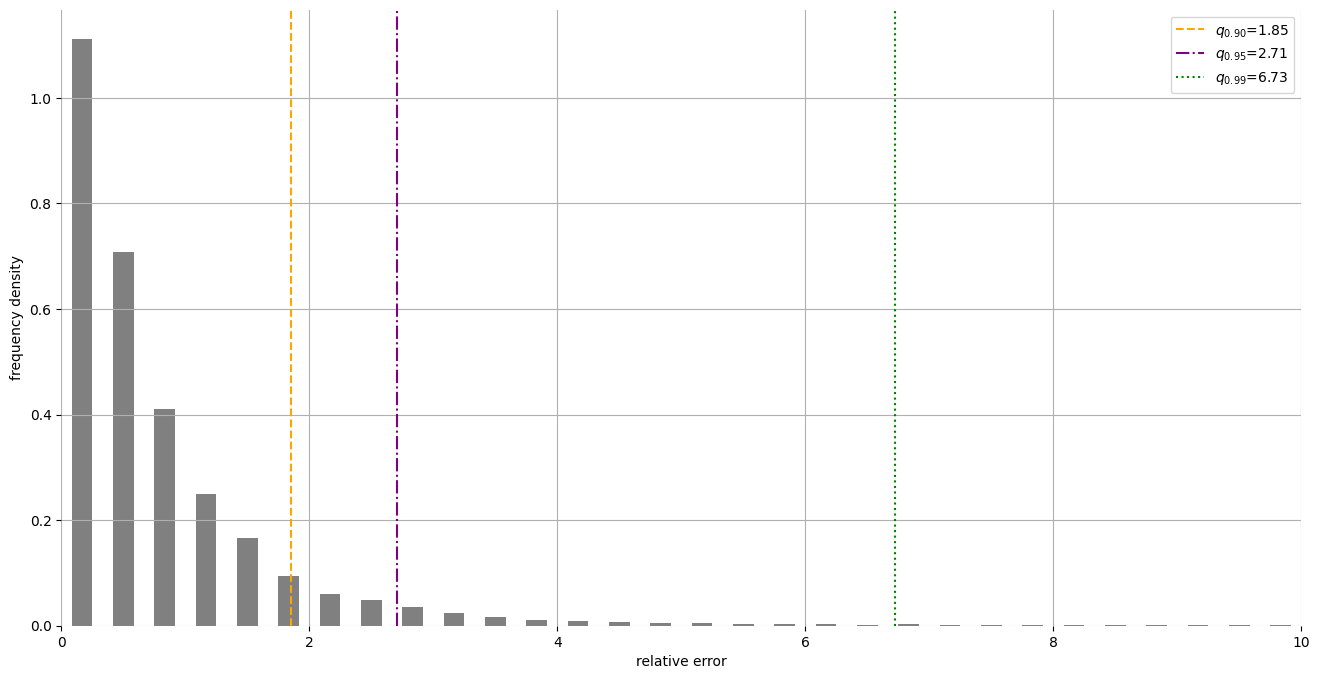

In [24]:
#illustrate error distribution on test set
pred_test = model.predict(X_test).flatten()
true_test = Y_test.values.flatten()
relative_error = 100 * np.abs(pred_test - true_test) / true_test
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*np.array(relative_error).size)]
q_95 = sorted_re[int(0.95*np.array(relative_error).size)]
q_99 = sorted_re[int(0.99*np.array(relative_error).size)]
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 50, 151), density=True, rwidth=0.5, color='grey')
plt.xlim((0, 10))
sns.despine(left=True, bottom=True, right=True)
plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange', label=r"$q_{0.90}$"+"={:.2f}".format(q_90))
plt.axvline(x=q_95, ls='-.', color='purple', label=r"$q_{0.95}$"+"={:.2f}".format(q_95))
plt.axvline(x=q_99, ls=':', color='green', label=r"$q_{0.99}$"+"={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

<b>Testing the calibration</b>

In [19]:
from utils import heston_pricer

In [550]:
log_moneyness = np.linspace(-0.15, 0.15, 30)
maturity = np.linspace(0.01, 1, 30)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['Moneyness', 'Time to Maturity (years)', 'kappa', 'sigma', 'sigma', 'rho', 'v0']
#for some heston parameters, try to calibrate the heston model given the iv data 

df = pd.DataFrame(columns=train.columns)
df['Moneyness'] = np.exp(log_moneyness.flatten())
df['Time to Maturity (years)'] = maturity.flatten()
df['kappa'] = 1                                              
df['theta'] = 0.1                                           
df['sigma'] = 1                                 
df['rho'] = -0.75                                   
df['v0'] = 0.01                                                                               

In [551]:
df['iv'] = df.progress_apply(lambda row: heston_pricer(row['kappa'], row['theta'], row['sigma'], row['rho'], row['v0'], 
                                                      0 , 0, row['Time to Maturity (years)'], 1.0, row['Moneyness'])[1], axis=1)

100%|██████████| 900/900 [00:06<00:00, 136.18it/s]


In [552]:
#before predicting we need to scale the features to the same scale as the training data
scaled_features = SCALER.transform(df.iloc[:, :-1])
df['iv_nn'] = model.predict(scaled_features)


29/29 [==============================] - 0s 2ms/step


In [605]:
def plot_heatmap(data, values='re'):
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot_table(index='Time to Maturity (years)', columns='Log Moneyness', values=values, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap='coolwarm', cbar=True,
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.title(values, fontsize=18)
    plt.xlabel('Log Moneyness', fontsize=18)
    plt.ylabel('Time to Maturity (years)', fontsize=18)
    #axisfont size
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=16)
    plt.show()

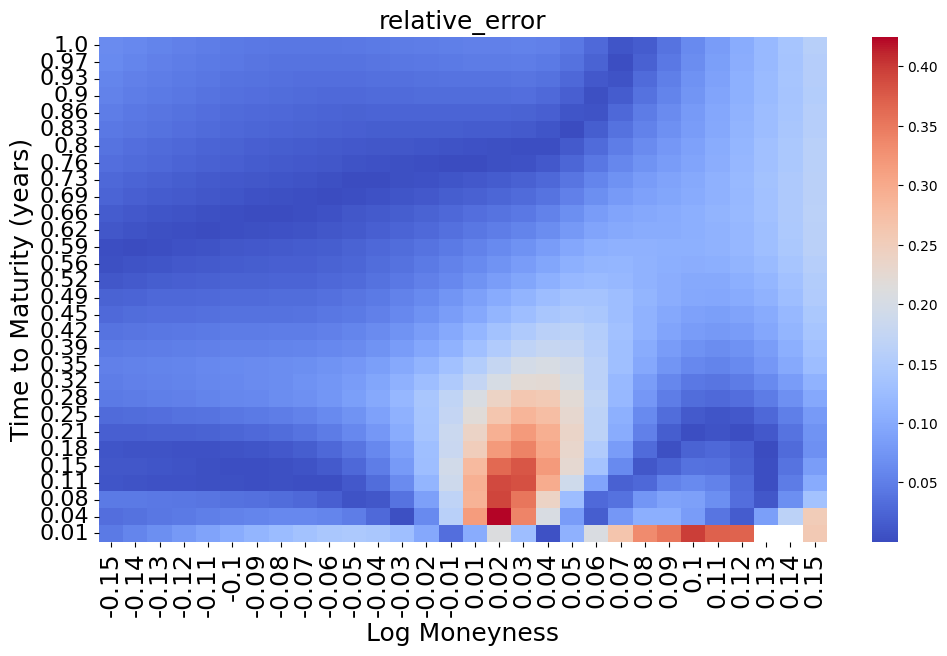

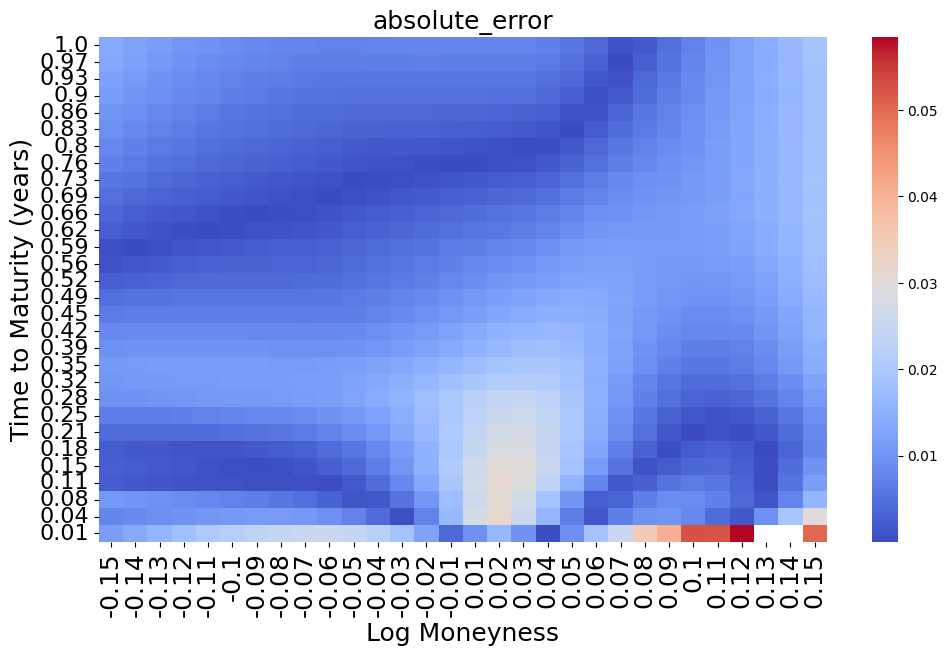

In [606]:
df['Log Moneyness'] = log_moneyness.flatten()
df['relative_error'] = np.abs(df['iv_nn'] - df['iv']) / df['iv']
plot_heatmap(df, 'relative_error')
df['absolute_error'] = np.abs(df['iv_nn'] - df['iv'])
plot_heatmap(df, 'absolute_error')

In [285]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    
    fig = plt.figure(figsize=(12, 6))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = 'coolwarm')#plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()

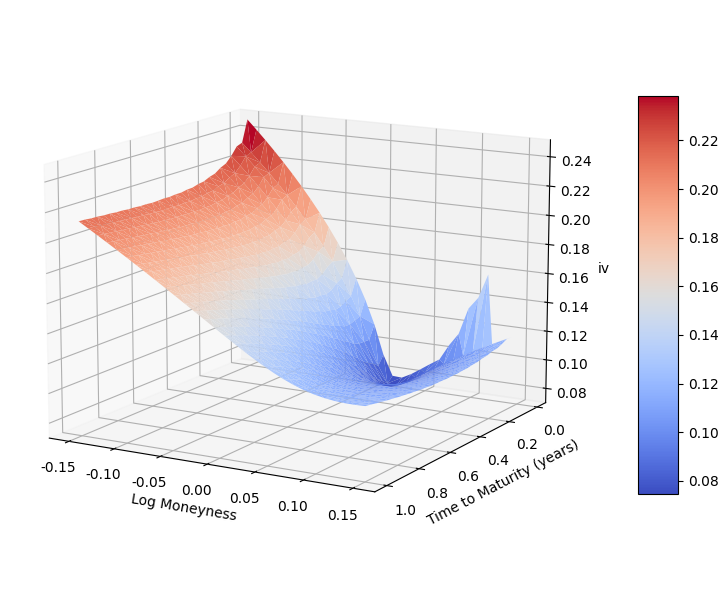

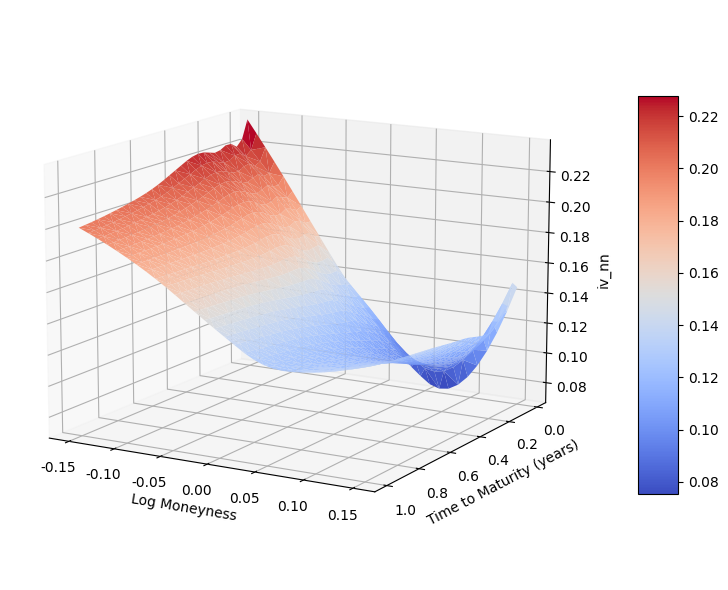

In [134]:
plot_iv_surface(df, z='iv')
plot_iv_surface(df, z='iv_nn')

<b>Heston Deep Calibration</b>

In [286]:
def jacobian_LM(params):
    # Extract the estimated parameters from the input vector
    
    kappa, theta, sigma, rho, v0 = params
    #kappa is no valid name in python
    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['kappa'] = kappa
    inputs['theta'] = theta
    inputs['sigma'] = sigma
    inputs['rho'] = rho
    inputs['v0'] = v0



    #convert to tensor
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the inputs to calculate the gradients
        tape.watch(inputs)
        
        # Use the trained neural network model to predict implied volatility
        predicted_vola = model(inputs)
    
    # Calculate the gradients of the predicted implied volatility with respect to the parameters
    gradients = tape.gradient(predicted_vola, inputs)
    
    # Extract the gradients of the estimated parameters
    dkappa, dtheta, dsigma, drho, dv0 = tf.unstack(gradients[:, 2:7], axis=1)
    
    # Return the Jacobian matrix with dimensions Nx4
    return np.array(tf.stack([dkappa, dtheta, dsigma, drho, dv0], axis=1))

# cost function for Levenberg-Marquardt, can be used in a Scipy optimizer
def cost_function_LM(params):
    # Unpack the parameters
    kappa, theta, sigma, rho, v0 = params

    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['kappa'] = kappa
    inputs['theta'] = theta
    inputs['sigma'] = sigma
    inputs['rho'] = rho
    inputs['v0'] = v0
    
    # Make predictions using the neural network model
    predictions = model.predict(inputs)

    # Calculate the mean squared error (MSE) between predictions and targets
    me = np.mean(predictions - actual_vola, axis=0)

    return me   #returns array of shape (n,1)


In [287]:
from scipy.stats import truncnorm

def model_parameters_initializer(model='heston', random_seed=None):
    """ Initialize model parameters
    """
    if model == 'heston':
        params = [
            10 * np.random.rand(), # kappa
            np.random.rand(), # theta
            5 * np.random.rand(), # sigma
            -1 * np.random.rand(), # rho
            np.random.rand() # v0
        ]
        names = ['kappa', 'theta', 'sigma', 'rho', 'v0']          #kappa theta sigma rho v0
    elif model == 'rbergomi' or model == 'rBergomi':
        params = [
            truncnorm.rvs(-1.2, 8.6, 0.07, 0.05), # H
            truncnorm.rvs(-3, 3, 2.5, 0.5), # sigma
            truncnorm.rvs(-0.25, 2.25, -0.95, 0.2), # rho
            truncnorm.rvs(-2.5, 7, 0.3, 0.1)**2 # v0
        ]
        names = ['H', 'sigma', 'rho', 'v0']
    else:
        raise NameError("No such model name: {}".format(model))
    return params, names

In [288]:
def manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75):
    #ignore rfr
    params = initial_params
    
    n_samples = moneyness.shape[0]
    n_params = np.array(initial_params).size #=5
    #identity matrix for stability as regularizer
    I = np.eye(n_params)    #5x5, rfr disregarded
    Q = pd.DataFrame(actual_vola) # shape: [n_samples, 1]


    iteration = 0  # Initialize iteration count
    
    kappa, theta, sigma, rho, v0 = initial_params              #rfr not optiimized
    #make a df
    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['kappa'] = kappa
    inputs['theta'] = theta
    inputs['sigma'] = sigma
    inputs['rho'] = rho
    inputs['v0'] = v0




    prediction = model.predict(inputs)
    jac = jacobian_LM(initial_params) #Nx5
    R = prediction - Q.values #absolute error Nx1
    A0 = jac.T.dot(jac) #5x5
    A = np.linalg.pinv(A0 + learning_rate * I) #5x5
    B = jac.T.dot(R) #5x1
    delta_params = A.dot(B).flatten() #5x1


    while iteration < max_iterations and np.linalg.norm(delta_params) > tolerance:
        if iteration % 2 == 0:
        #Print the loss every 10 terations
            print("Iteration: {0}, Loss: {1}".format(iteration, np.sum(abs(R))))

        params_new = params - delta_params
        #restrict parameters to the defined and transformed bounds
        params_new = np.clip(params_new, lower_bounds, upper_bounds)

        inputs['kappa'] = params_new[0]
        inputs['theta'] = params_new[1]
        inputs['sigma'] = params_new[2]
        inputs['rho'] = params_new[3]
        inputs['v0'] = params_new[4]

        #rfr unchanged

        prediction = model.predict(inputs)
        jac_new = jacobian_LM(params_new) #Nx5
        R_new = prediction - Q.values #absolute error Nx1
        R_norm = np.linalg.norm(R)
        c_mu = (R_norm - np.linalg.norm(R_new)) / (R_norm - np.linalg.norm(R - jac.dot(delta_params)))

        if c_mu <= LR_lower:
            #increase learning rate
            learning_rate *= 2
            params = params_new
            
            R = R_new
            jac = jac_new
            print("Learning rate increased to {}".format(learning_rate))
        else:
            params = params_new
            R = R_new
            jac = jac_new
        if c_mu >=LR_upper:
            learning_rate /= 2.0
            print("Learning rate decreased to {}".format(learning_rate))
            #reduce learning rate
        A0 = jac.T.dot(jac) #5x5
        A = np.linalg.pinv(A0 + learning_rate * I) #5x5
        B = jac.T.dot(R) #5x1
        delta_params = A.dot(B).flatten() #5x1

        iteration += 1  # Increment iteration count

    if iteration < max_iterations:
        print("Leave iterations early after {} iters".format(iteration))

    rmse = np.sqrt(np.mean(np.square(prediction - Q), axis=None))
    print("FINAL RMSE: {}".format(rmse))
    mse = np.mean(np.square(prediction - Q), axis=None)
    mae = np.mean(np.abs(prediction - Q), axis=None)
    mre = np.mean(np.abs(prediction - Q) / Q, axis=None)
    median_se = np.median(np.square(prediction - Q), axis=None)    
    
    return params, rmse, mse, mae, mre, median_se

In [22]:
initial_params = model_parameters_initializer('heston')[0]
# parameters have to be scaled into the NN dimensions in order not to be out of bounds during initialization, done later

#test given the sample generated above to test the NN
data = pd.DataFrame()
data['Moneyness'] = df['Moneyness'].values
data['Time to Maturity (years)'] = df['Time to Maturity (years)'].values
#dummy to rescale, not used
data['kappa'] = initial_params[0]
data['theta'] = initial_params[1]
data['sigma'] = initial_params[2]
data['rho'] = initial_params[3]
data['v0'] = initial_params[4]

datascaled = SCALER.transform(data)
moneyness = datascaled.iloc[:, 0].values
time_to_maturity = datascaled.iloc[:, 1].values
initial_params = datascaled.iloc[0, 2:].values      #initial guess is rescaled to the NN feature space
#calibrate to reach this vola
actual_vola = df['iv_nn'].values                    #we try to retrieve the parameters we used to generate the surface in df

NameError: name 'df' is not defined

In [32]:
#scipy Levenberg-Marquardt, gives bad results
import scipy.optimize
resultLM = scipy.optimize.least_squares(
    cost_function_LM,
    initial_params,
    jacobian_LM,
    bounds=bounds,
    gtol=1E-15
)

NameError: name 'bounds' is not defined

In [33]:
dfres_manual = pd.DataFrame()
dfres_manual['Moneyness'] = moneyness
dfres_manual['Time to Maturity (years)'] = time_to_maturity
dfres_manual['kappa'] = resultLM.x[0]
dfres_manual['theta'] = resultLM.x[1]
dfres_manual['sigma'] = resultLM.x[2]
dfres_manual['rho'] = resultLM.x[3]
dfres_manual['v0'] = resultLM.x[4]
pred_iv = model.predict(dfres_manual)
dfres_manual = SCALER.inverse_transform(dfres_manual)
dfres_manual['calibrated iv (Levemberg-Marquardt)'] = pred_iv
dfres_manual['iv'] = actual_vola
dfres_manual['relative_error'] = np.abs(dfres_manual['calibrated iv (Levemberg-Marquardt)'] - dfres_manual['iv']) / dfres_manual['iv']
dfres_manual['Log Moneyness'] = np.log(dfres_manual['Moneyness'])
dfres_manual['absolute_error'] = np.abs(dfres_manual['calibrated iv (Levemberg-Marquardt)'] - dfres_manual['iv'])
print("Mean relative error: {}".format(np.mean(dfres_manual['relative_error'])))
print("Mean absolute error: {}".format(np.mean(dfres_manual['absolute_error'])))
plot_iv_surface(dfres_manual, z='calibrated iv (Levemberg-Marquardt)')
plot_iv_surface(dfres_manual, z='iv')
plot_heatmap(dfres_manual, 'relative_error')
plot_heatmap(dfres_manual, 'absolute_error')

NameError: name 'resultLM' is not defined

In [ ]:
#test jacobian
print(jacobian_LM(result_manual)) 

In [ ]:
result_manual, rmse, mse, mae, mre = manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75)

In [ ]:
dfres_manual = pd.DataFrame()
dfres_manual['Moneyness'] = moneyness
dfres_manual['Time to Maturity (years)'] = time_to_maturity
dfres_manual['kappa'] = result_manual[0]
dfres_manual['theta'] = result_manual[1]
dfres_manual['sigma'] = result_manual[2]
dfres_manual['rho'] = result_manual[3]
dfres_manual['v0'] = result_manual[4]
pred_iv = model.predict(dfres_manual)
dfres_manual = SCALER.inverse_transform(dfres_manual)
dfres_manual['calibrated iv (manual solver)'] = pred_iv
dfres_manual['iv'] = actual_vola
dfres_manual['relative_error'] = np.abs(dfres_manual['calibrated iv (manual solver)'] - dfres_manual['iv']) / dfres_manual['iv']
dfres_manual['Log Moneyness'] = np.log(dfres_manual['Moneyness'])
dfres_manual['absolute_error'] = np.abs(dfres_manual['calibrated iv (manual solver)'] - dfres_manual['iv'])
print("Mean relative error: {}".format(np.mean(dfres_manual['relative_error'])))
print("Mean absolute error: {}".format(np.mean(dfres_manual['absolute_error'])))
plot_iv_surface(dfres_manual, z='calibrated iv (manual solver)')
plot_iv_surface(dfres_manual, z='iv')
plot_heatmap(dfres_manual, 'relative_error')
plot_heatmap(dfres_manual, 'absolute_error')

<i>Bounds are  used in the manual solver to restrict the parameters to a reasonable range</i>

In [289]:
#these are the bounds in the initial space
lower_bounds = [0, 0, 0, -1, 0]  # Lower bounds for kappa, theta, sigma, rho, v0
upper_bounds = [10, 1, 8, 1, 2]  # Upper bounds for kappa, theta, sigma, rho, v0
#v0 adjusted to 2 for covid


#these are the bounds in the scaled space where the optimization is performed
dummy = pd.DataFrame()
dummy['Moneyness'] = np.array([0,0])
dummy['Time to Maturity (years)'] = np.array([0,0])
dummy['kappa'] = np.array([lower_bounds[0], upper_bounds[0]])
dummy['theta'] = np.array([lower_bounds[1], upper_bounds[1]])
dummy['sigma'] = np.array([lower_bounds[2], upper_bounds[2]])
dummy['rho'] = np.array([lower_bounds[3], upper_bounds[3]])
dummy['v0'] = np.array([lower_bounds[4], upper_bounds[4]])





dummy_scaled = SCALER.transform(dummy)

lower_bounds = dummy_scaled.iloc[0, 2]
upper_bounds = dummy_scaled.iloc[1, 2]

bounds = (lower_bounds, upper_bounds)
bounds
lower_bounds = np.array(lower_bounds)
upper_bounds = np.array(upper_bounds)

<b>Application to real data</b>

In [290]:
from helpers import *

In [648]:
year = 2019
for i in range(5,6):
    month = i
    df1 = helpers.load_month(year, month,'SPX')
    df1,len = helpers.split_days(df1, num_groups = 1)

    #store the results in a df
    results = pd.DataFrame(columns=['date', 'kappa', 'theta', 'sigma', 'rho', 'v0', 'rmse', 'mse', 'mae', 'mre', 'median_se'])


    subfolder_path = os.path.join(os.getcwd(), "HestonFiles_iterations")

    dates, percent = helpers.init()

    for zz in range(1):

        df2 = df1[6-1]
        
        

        #only use traded quotes, this is already done in the pre-processing and just to be sure no illiquid quotes are left over
        #df = df[df[' [C_VOLUME]'] > 0]
        df2 = df2[df2[' [C_VOLUME]'] != " "]
        df2 = df2[df2[' [C_VOLUME]'] != ""]


        daysaddasint = np.array(helpers.get_daystomaturity(df2)).astype(int)
        strikes = np.array(helpers.get_strike(df2))
        implied_vols = np.array(helpers.get_IV_C(df2))
        year, month, day = helpers.get_pricingdate(df2)
        
        #convert to date
        date = datetime.date(year, month, day)

        spot = helpers.get_underlyinglast(df2)
            
        mean_vola = np.mean(implied_vols)

        down = 0.835
        up = 1.169

        filter1 = strikes > down*spot
        filter2 = strikes < up*spot
        filter3 = daysaddasint > 0
        filter4 = daysaddasint <= 368


        filter = filter1 & filter2 & filter3 & filter4

        implied_vols = implied_vols[filter].flatten()
        strikes = strikes[filter].flatten()/spot
        daysaddasint = daysaddasint[filter].astype(int).flatten()/365.0



        #add some buckets to the grid which we will use later
        adddays = np.linspace(0.01,1,6)
        short_end = np.array([0.01, 0.02, 0.03, 0.04]).flatten()    #they should be contained in the grid
        daysaddasint = np.concatenate((np.round(np.concatenate((daysaddasint, adddays))/0.05)*0.05,short_end))
        #
        strikesadd = np.round(np.linspace(0.85,1.15,9),2)
        strikes = np.round(np.concatenate((strikes, strikesadd))/0.03)*0.03
        atm = np.array(1.0).flatten()

        strikes = np.concatenate((strikes,atm))#at the money is out of rounding scheme
        #16x np.nan
        nans = np.repeat(np.nan, 10)
        implied_vols = np.concatenate((implied_vols, nans))


        daysaddasint_unique = sorted(np.unique(daysaddasint))

        consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})

        #use mean in case of dublicates
        consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


        # Pivot the dataframe to create the matrix
        volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')

        #interpolation is used to find outliers, therefore a much denser grid is needed, the interpolated values are not used for calibration
        try:
            volmatrix_interpolation = volmatrix.interpolate(method='quadratic')
        except:
            print("Interpolation failed")
            volmatrix_interpolation = volmatrix.copy()

        #remove negative values after interpolation
        volmatrix_interpolation[volmatrix_interpolation < 0] = np.nan

        # outlier detection, one iteration already gives good results 
        # we iterate over smiles and check each smile for outliers
        for i, ds in enumerate(np.array(daysaddasint_unique)):
            first_col = volmatrix_interpolation.iloc[:, i]
            y = first_col.values
            # Smooth the data using a Savitzky-Golay filter
            
            # Calculate the absolute difference between y and y_smooth, more than 2% difference is considered an outlier
            diff = np.abs(y - savgol_filter(y, 6, 1, mode='interp'))> 0.02

            #now we remove the outliers from the original matrix
            #without the interpolation, the outlier detection is not as good
            volmatrix.iloc[diff, i] = np.nan
            volmatrix_interpolation.iloc[diff, i] = np.nan

            
        dates_unique = sorted(np.unique(volmatrix.columns))

        strikes_unique = sorted(volmatrix.index.astype(float))


        try:
            a = volmatrix.interpolate(method='quadratic', axis=0)
        except:
            print("Interpolation failed")
            a = volmatrix.copy()
        try:    
            b = a.interpolate(method='quadratic', axis=1)
            b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)
        except:
            print("Interpolation failed")
            b = a.copy()


        datf = b.stack().reset_index()
        datf.columns = ['Moneyness', 'Time to Maturity', 'iv']


        rmse_best = 10000000.0
        for i in range(0,4):
            initial_params = model_parameters_initializer('heston')[0]
            # parameters have to be scaled into the NN dimensions in order not to be out of bounds during initialization, done later
            #test given the sample generated above to test the NN
            data = pd.DataFrame()
            data['Moneyness'] = datf['Moneyness'].values
            data['Time to Maturity (years)'] = datf['Time to Maturity'].values
            #dummy to rescale, not used
            data['kappa'] = initial_params[0]
            data['theta'] = initial_params[1]
            data['sigma'] = initial_params[2]
            data['rho'] = initial_params[3]
            data['v0'] = initial_params[4]

            datascaled = SCALER.transform(data)
            moneyness = datascaled.iloc[:, 0].values
            time_to_maturity = datascaled.iloc[:, 1].values
            initial_params = datascaled.iloc[0, 2:].values      #initial guess is rescaled to the NN feature space
            #calibrate to reach this vola
            actual_vola = datf['iv'].values                    #we try to retrieve the parameters we used to generate the surface in df


            result_manual, rmse, mse, mae, mre, median_se = manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75)
           
            if rmse.iloc[0] < rmse_best:
                #convert the optimal parameters back to the original space
                data = pd.DataFrame()
                data['Moneyness'] = [1.0]
                data['Time to Maturity (years)'] = [1.0]
                data['kappa'] = result_manual[0]
                data['theta'] = result_manual[1]
                data['sigma'] = result_manual[2]
                data['rho'] = result_manual[3]
                data['v0'] = result_manual[4]
                rmse_best = rmse.iloc[0]

                data = SCALER.inverse_transform(data)
                #split the result into the df
                results.loc[zz] = [date, data.iloc[0, 2], data.iloc[0, 3], data.iloc[0, 4], data.iloc[0, 5], data.iloc[0, 6], rmse, mse, mae, mre, median_se]

    results['rmse'] = results['rmse'].astype(float)
    results['mse'] = results['mse'].astype(float)
    results['mae'] = results['mae'].astype(float)
    results['mre'] = results['mre'].astype(float)
    results['median_se'] = results['median_se'].astype(float)

    #save the results and include the month and year in the filename
    file_path = os.path.join(subfolder_path, "Heston_calibration{}_4_trials.csv".format(str(year)+str(month)))
    #results.to_csv(file_path, index=False)

9/9 [==============================] - 0s 3ms/step
Iteration: 0, Loss: 75.22831770754328
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 23.34986761819527
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 2.4
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 22.877409807085225
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 22.76982934072485
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 38.4
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 22.744130752427115
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 153.6
9/9 [=========

c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()

9/9 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 30.53841374214095
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 2.4
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 28.019919618946545
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 27.40148361291699
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 38.4
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 27.24434947972167
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 153.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 307.2
Iteration: 10, Loss:

c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()

Iteration: 0, Loss: 58.255944843193745
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 27.44389025490549
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 2.4
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 25.924969707483026
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 25.61159851972507
9/9 [==============================] - 0s 6ms/step
Learning rate increased to 38.4
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 25.535521612956444
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 153.6
9/9 [==============================] - 0s 2ms/step
Learning rate

c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()

9/9 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 23.423159676619957
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 2.4
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 23.76692312900224
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 23.639928887977355
9/9 [==============================] - 0s 3ms/step
Learning rate increased to 38.4
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 23.60067239372878
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 153.6
9/9 [==============================] - 0s 2ms/step
Learning rate increased to 307.2
Iteration: 10, Loss

c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()

In [649]:
#get last row of results
lastrow = results.iloc[-1, :]
date = lastrow['date']
lastrow

date         2019-05-08
kappa          2.771264
theta          0.952513
sigma           4.72397
rho            -0.89621
v0             0.219589
rmse           0.108505
mse            0.011773
mae            0.084835
mre            0.197755
median_se      0.005773
Name: 0, dtype: object

<b>Sample visualization</b>

In [650]:
data = pd.DataFrame()
data['Moneyness'] = datf['Moneyness'].values
data['Time to Maturity (years)'] = datf['Time to Maturity'].values
data['iv'] = datf['iv'].values
data['Log Moneyness'] = np.log(data['Moneyness'])
kappa, theta, sigma, rho, v0 = lastrow[1:6].values
hestonvola = data.progress_apply(lambda row: heston_pricer(kappa, theta, sigma, rho, v0,0,0, row['Time to Maturity (years)'], 1.0, row['Moneyness'])[1], axis=1)


100%|██████████| 268/268 [00:02<00:00, 117.38it/s]


In [653]:
def plot_iv_surface_play(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    
    fig = plt.figure(figsize=(12, 6))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x, fontsize=13)
    ax.set_ylabel(y, fontsize=13)
    ax.set_zlabel(z, fontsize=13)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap='coolwarm')
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    ax.set_title('')
    plt.tight_layout()


    # Add centered text below the chart, rounded to 2 decimal places
    header_text = 'kappa: {}, theta: {}, sigma: {}, rho: {}, v0: {}'.format(kappa, theta, sigma, rho, v0)
    ax.text2D(0.08, 0.85, header_text, transform=ax.transAxes, fontsize=14)
    # header_text = 'Market Implied Volatility'
    # ax.text2D(0.28, 0.85, header_text, transform=ax.transAxes, fontsize=18)
    #add date as text
    ax.text2D(0.45, 0.9, date, transform=ax.transAxes, fontsize=18)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #size of vertical axis
    ax.zaxis.set_tick_params(labelsize=13)
    #round horizontal axis to 2 decimals
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    plt.tight_layout()
    plt.show()


C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\1638830627.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


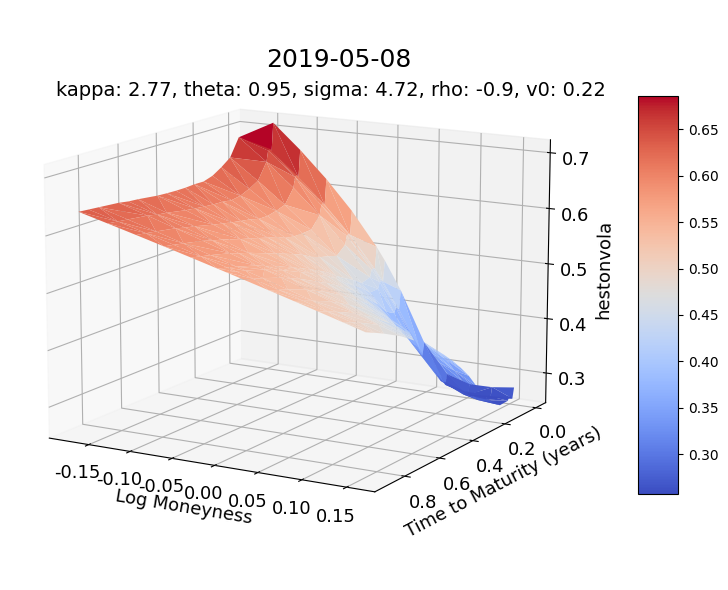

In [654]:
kappa = round(kappa, 2)
theta = round(theta, 2)
sigma = round(sigma, 2)
rho = round(rho, 2)
v0 = round(v0, 2)

data['hestonvola'] = hestonvola
plot_iv_surface_play(data, z='hestonvola')

C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\1521273958.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


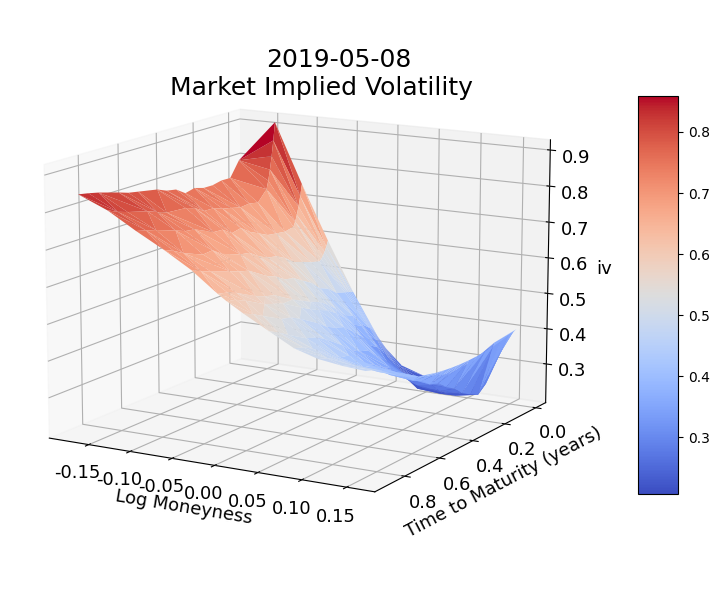

In [652]:
plot_iv_surface_play(data, z='iv')

Mean relative error: 0.147315314415407
Mean absolute error: 0.029005270710563382


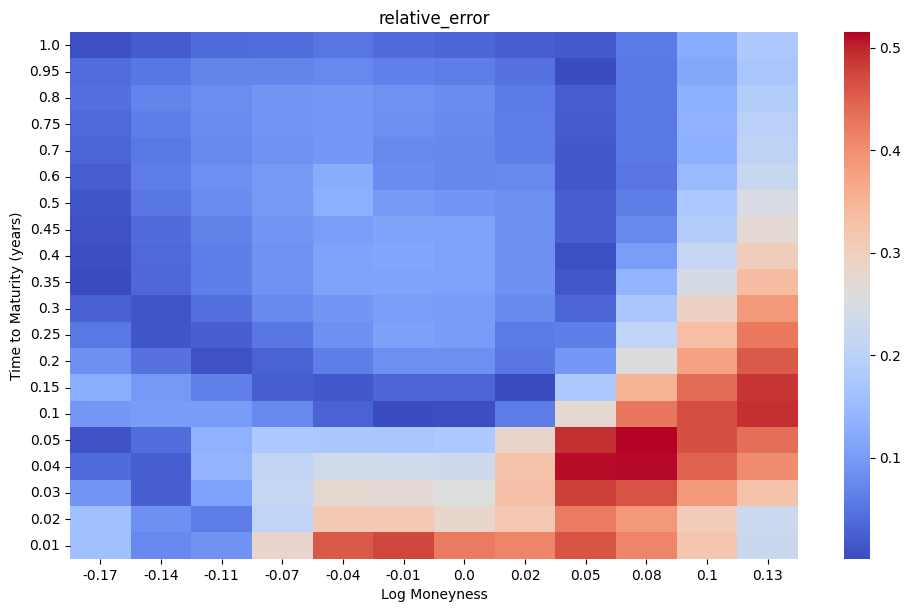

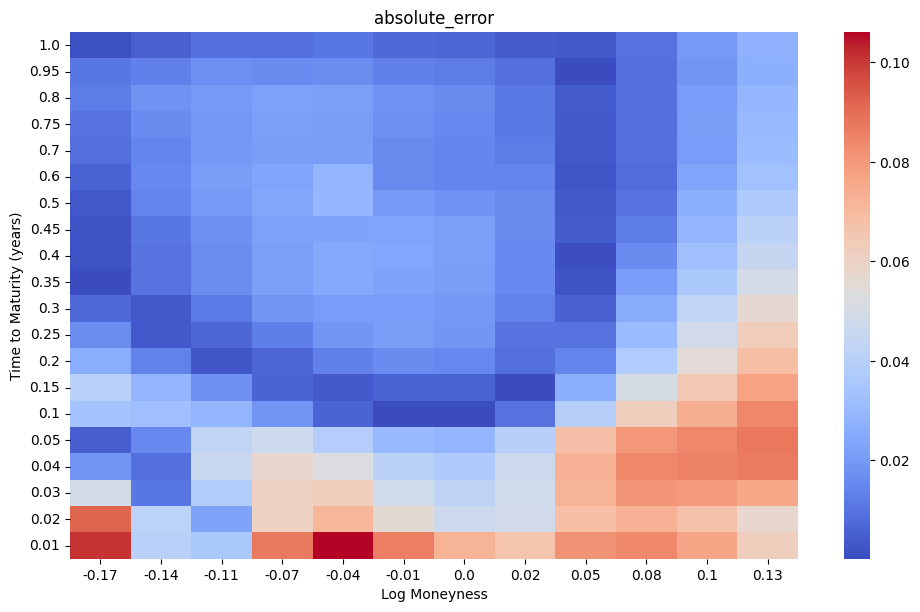

In [38]:
data['relative_error'] = np.abs(data['hestonvola'] - data['iv']) / data['iv']
data['absolute_error'] = np.abs(data['hestonvola'] - data['iv'])
print("Mean relative error: {}".format(np.mean(data['relative_error'])))
print("Mean absolute error: {}".format(np.mean(data['absolute_error'])))
plot_heatmap(data, 'relative_error')
plot_heatmap(data, 'absolute_error')

<b>Showing full time series<b>

In [884]:
#load all files from
subfolder_path = os.path.join(os.getcwd(), "HestonFiles_iterations")
files = os.listdir(subfolder_path)
files = [f for f in files if f.endswith('.csv')]
#load files to csv
df = pd.DataFrame()
for f in files:
    df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
allresults = df.copy()
df.head()

C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\220132395.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\220132395.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\220132395.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\220132395.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.appen

date     kappa     theta     sigma       rho        v0      rmse  \
0 2019-01-02  4.074823  0.048208  1.649422 -0.444620  0.030397  0.033915   
0 2019-01-02  2.881766  0.142571  4.296195 -0.640038  0.077466  0.063013   
1 2019-01-03  4.470450  0.104847  4.114565 -0.688772  0.126927  0.070270   
2 2019-01-04  4.425769  0.118858  4.999861 -0.671216  0.089675  0.066739   
3 2019-01-07  4.413689  0.107395  4.999861 -0.610699  0.084895  0.065265   

        mse       mae       mre  median_se  
0  0.001150  0.022973  0.138636   0.000377  
0  0.003971  0.036402  0.150484   0.000487  
1  0.004938  0.036469  0.127545   0.000360  
2  0.004454  0.037363  0.151404   0.000485  
3  0.004260  0.038420  0.162781   0.000520

In [885]:
#with helpers load interest rate
dates, percents = helpers.init()

In [886]:
rfr = pd.DataFrame()
rfr['date'] = dates
rfr['rfr'] = percents
rfr['date'] = pd.to_datetime(rfr['date'])
df = df.merge(rfr, on='date', how='left')

In [888]:
# #filter all values where rmse is 50% above 30 days moving rmse
# df = df[df['rmse'] < 30*df['rmse'].rolling(30).mean()]

df = df[df['theta'] < 2* df['theta'].rolling(5).min()]
# df = df[df['rho'] > 3* df['rho'].rolling(30).median()]

# df = df[df['kappa'] < 4* df['kappa'].rolling(30).mean()]
df = df[df['rho'] > -1]

In [887]:
#make moving average of the parameters for weekly
df['rmedian_se'] = np.sqrt(df['median_se']).rolling(2).median()
df['kappa'] = df['kappa'].rolling(2).median()
df['theta'] = df['theta'].rolling(2).median()
df['sigma'] = df['sigma'].rolling(2).median()
df['rho'] = df['rho'].rolling(2).mean()
#df['v0'] = df['v0'].rolling(10).mean()
df['rmse'] = df['rmse'].rolling(2).median()
df['mse'] = df['mse'].rolling(2).median()
df['mae'] = df['mae'].rolling(2).median()
df['mre'] = df['mre'].rolling(2).median()
df['median_se'] = df['median_se'].rolling(2).median()

In [889]:
#30 days moving average of all parameters
df['kappa_30d'] = df['kappa'].rolling(30).mean()
df['theta_30d'] = df['theta'].rolling(30).mean()
df['sigma_30d'] = df['sigma'].rolling(30).mean()
df['rho_30d'] = df['rho'].rolling(30).mean()
df['v0_30d'] = df['v0'].rolling(30).mean()


In [890]:
df.head()

date     kappa     theta     sigma       rho        v0      rmse  \
5 2019-01-08  2.971449  0.167694  4.999861 -0.604560  0.078667  0.069763   
6 2019-01-09  4.253515  0.159507  4.694254 -0.679584  0.075699  0.064094   
7 2019-01-10  7.016893  0.084887  4.184769 -0.765203  0.092831  0.066392   
8 2019-01-11  6.601616  0.079805  3.925602 -0.709420  0.052562  0.065877   
9 2019-01-14  8.026187  0.068921  3.944476 -0.633050  0.099301  0.064744   

        mse       mae       mre  median_se     rfr  rmedian_se  kappa_30d  \
5  0.004887  0.041972  0.178724   0.000697  0.0278    0.026188        NaN   
6  0.004211  0.036901  0.159270   0.000556  0.0280    0.022501        NaN   
7  0.004563  0.033645  0.136586   0.000248  0.0280    0.015744        NaN   
8  0.004508  0.035017  0.155472   0.000316  0.0279    0.017689        NaN   
9  0.004332  0.036690  0.171290   0.000470  0.0278    0.021569        NaN   

   theta_30d  sigma_30d  rho_30d  v0_30d  
5        NaN        NaN      NaN     NaN  
6        NaN        NaN      NaN     NaN  
7        NaN        NaN      NaN     NaN  
8        NaN        NaN      NaN     NaN  
9        NaN        NaN      NaN     NaN

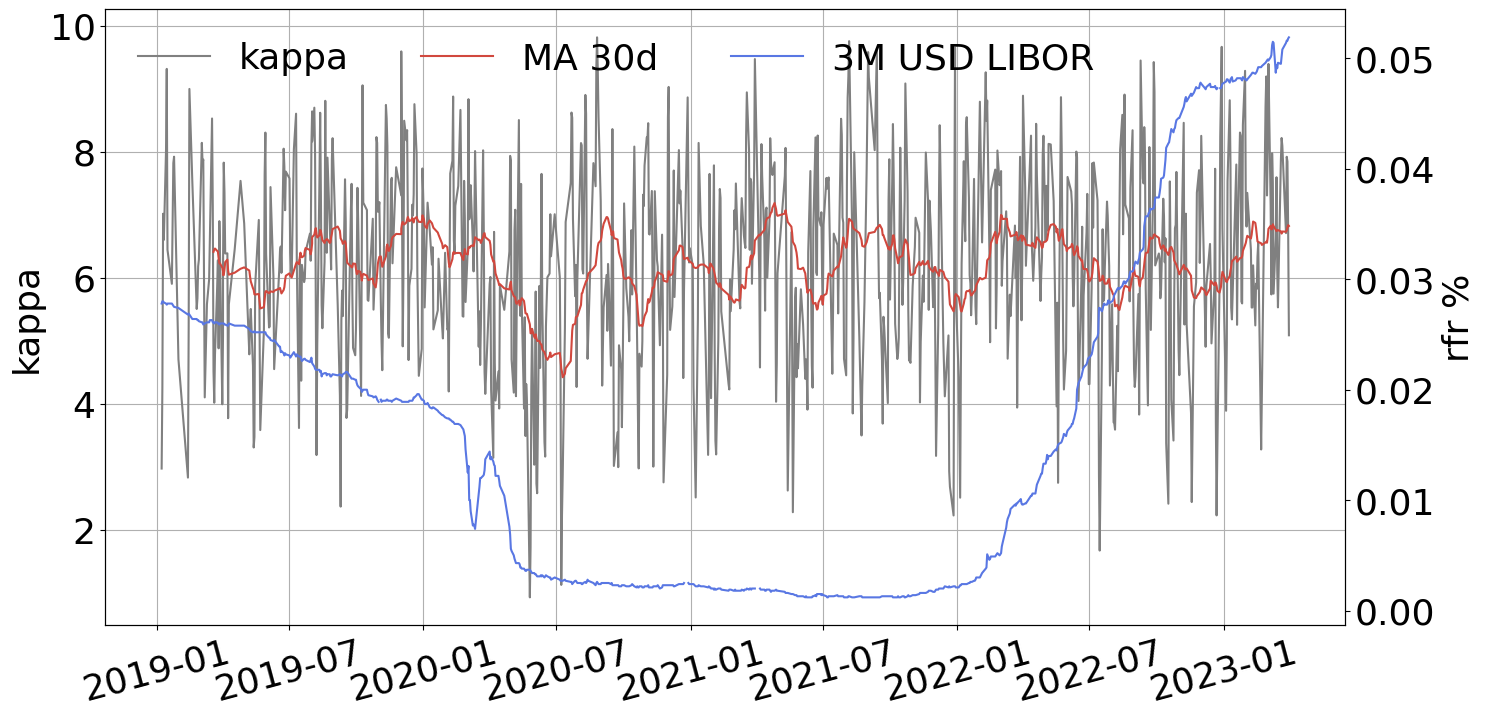

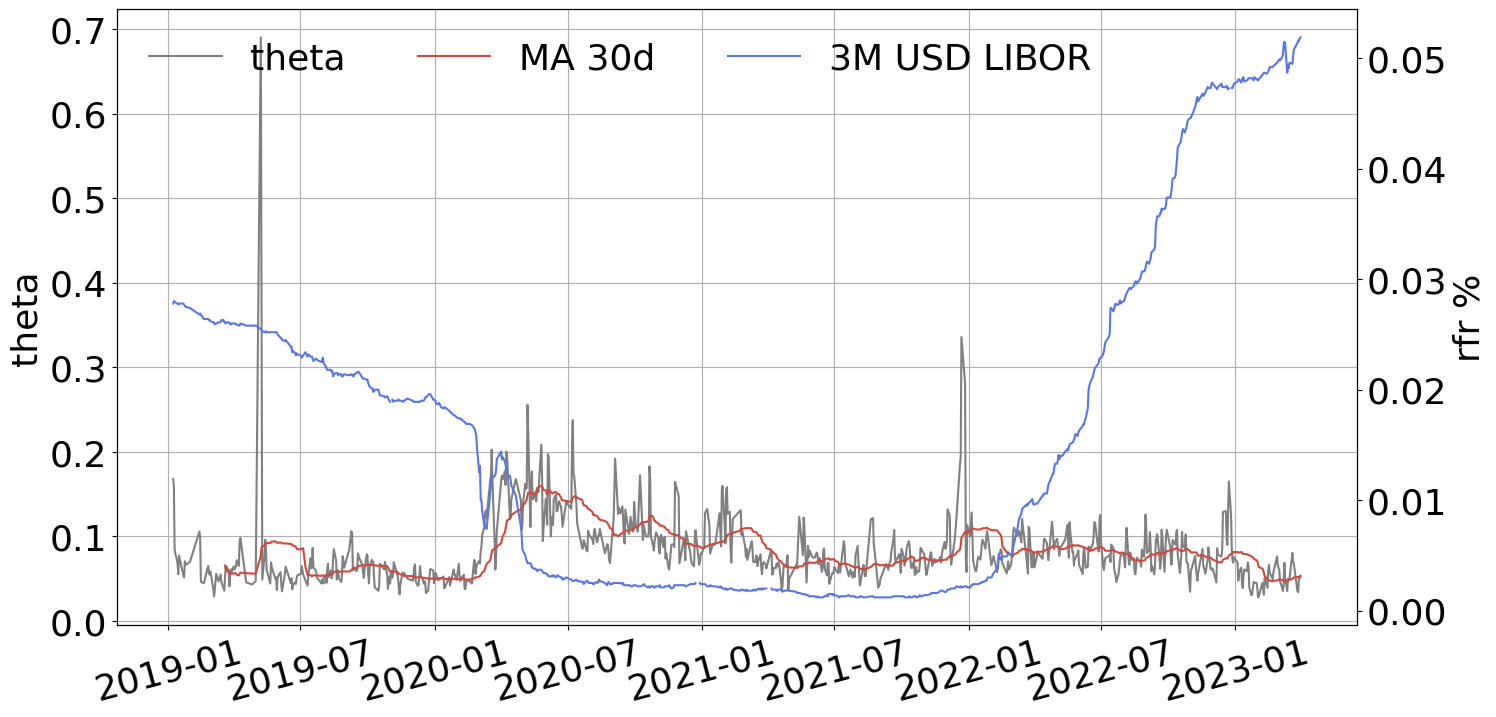

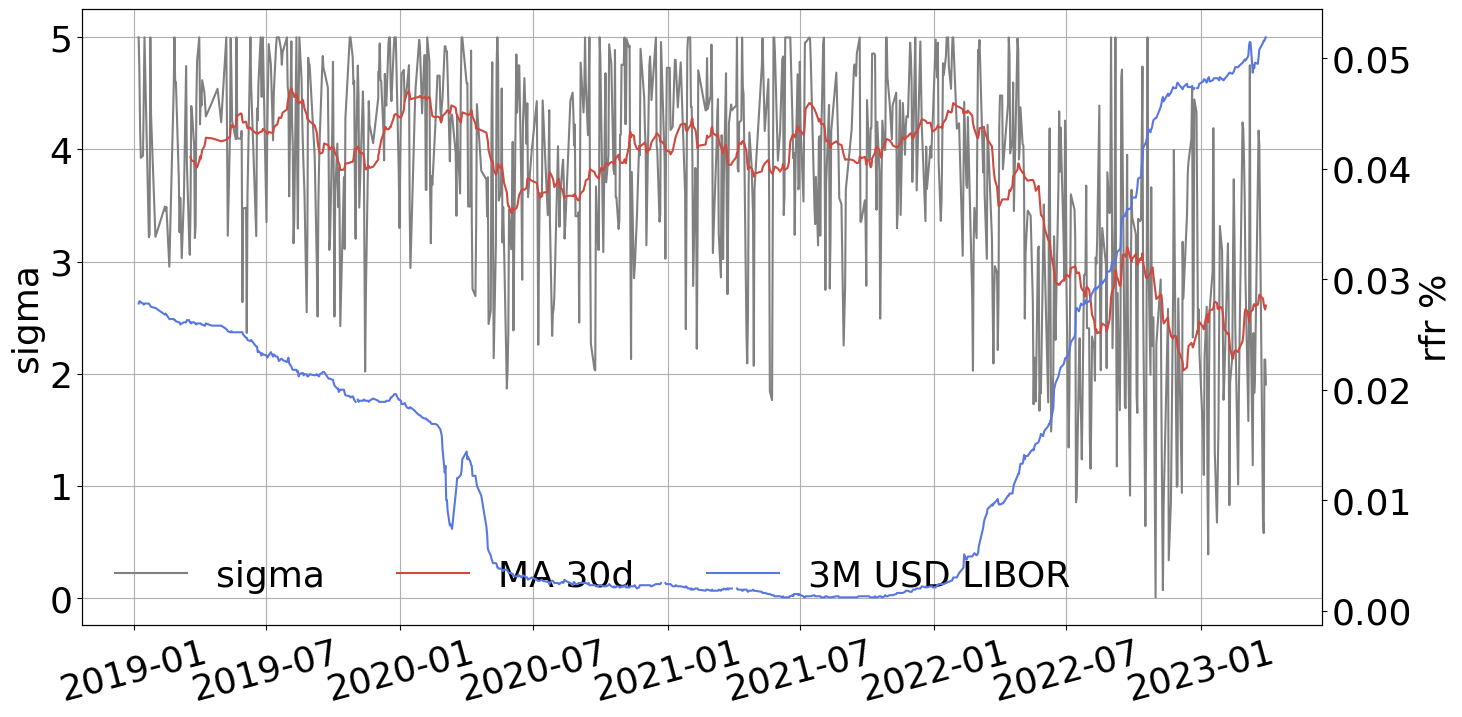

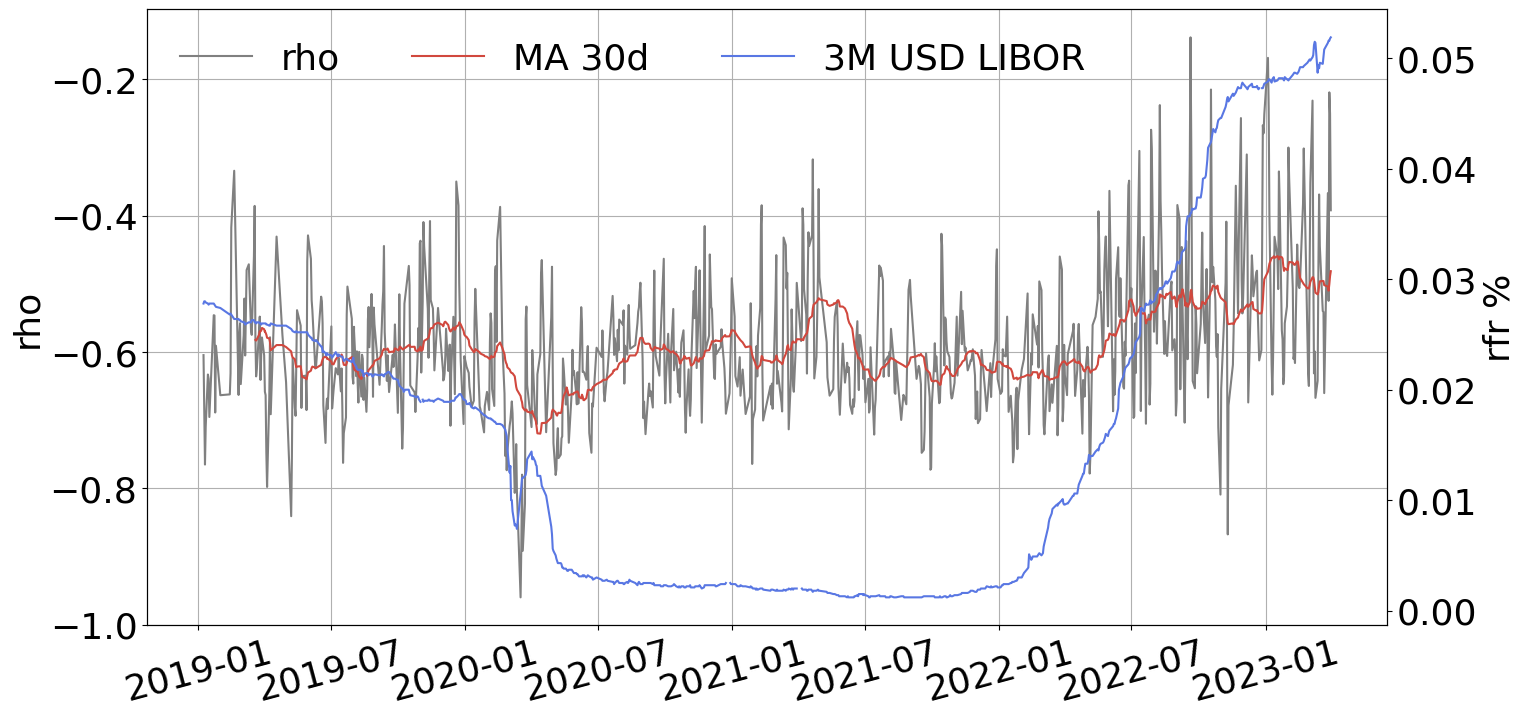

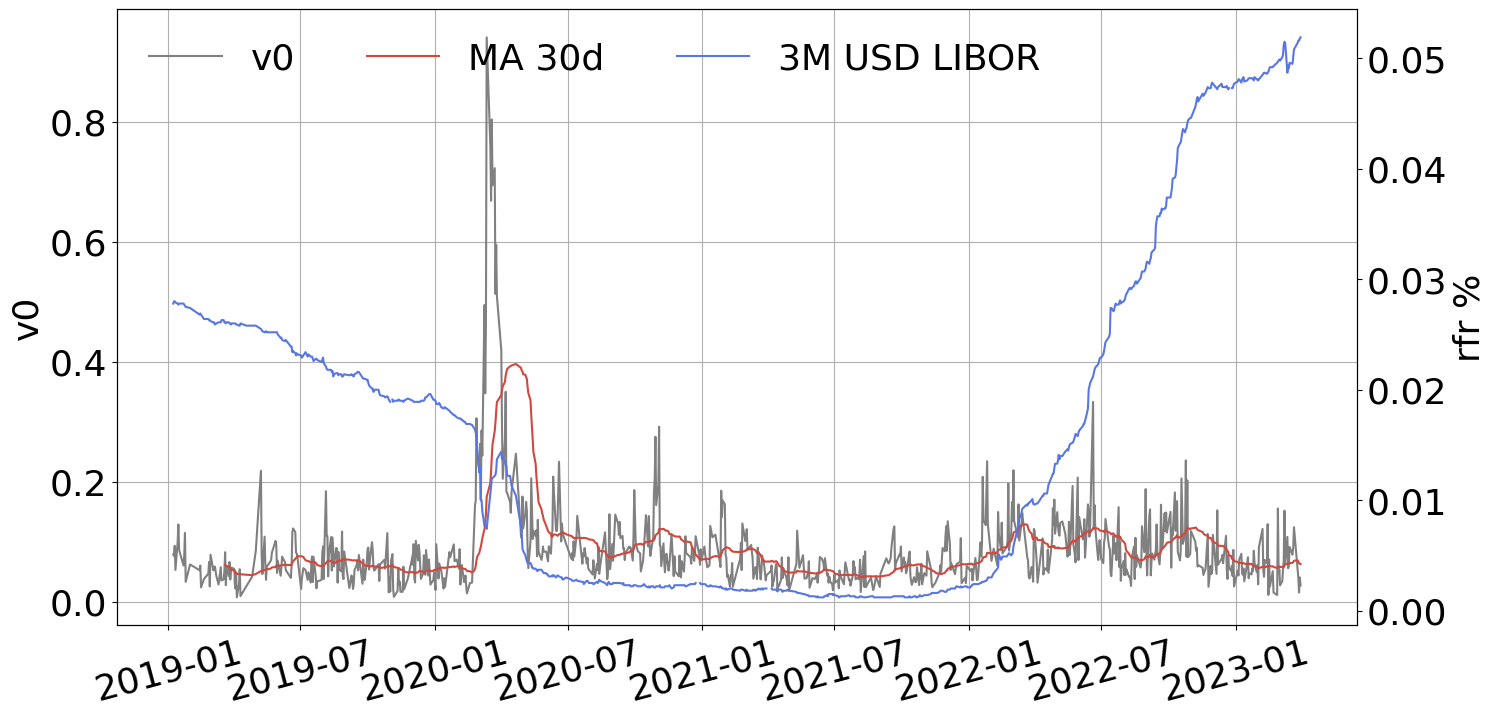

In [891]:
#in each heston parameter plot add the rfr and plot in grey and red, secondary axis for rfr, legend position topright

plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['kappa'], color='grey')
plt.plot(df['date'], df['kappa_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.plot([], [], color='#5977E3', label='rfr')  # Empty plot for legend
plt.legend(labels=['kappa','MA 30d', '3M USD LIBOR'], loc="upper left", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('kappa', fontsize=26)
ax2.set_ylabel('rfr %', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
#x axis values larger
ax2 = plt.twinx()
ax2.plot(df['date'], df['rfr'], color='#5977E3')
ax2.tick_params(labelsize=26)
#ax2 title
ax2.set_ylabel('rfr %', fontsize=26)
plt.show()
############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['theta'], color='grey')
plt.plot(df['date'], df['theta_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.plot([], [], color='#5977E3', label='rfr')  # Empty plot for legend
plt.legend(labels=['theta','MA 30d', '3M USD LIBOR'], loc="upper left", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('theta', fontsize=26)
ax2.set_ylabel('rfr %', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
#x axis values larger
ax2 = plt.twinx()
ax2.plot(df['date'], df['rfr'], color='#5977E3')
ax2.tick_params(labelsize=26)
#ax2 title
ax2.set_ylabel('rfr %', fontsize=26)
plt.show()

############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['sigma'], color='grey')
plt.plot(df['date'], df['sigma_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.plot([], [], color='#5977E3', label='rfr')  # Empty plot for legend
plt.legend(labels=['sigma', 'MA 30d', '3M USD LIBOR'], loc="lower left", frameon=False, fontsize=26, ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('sigma', fontsize=26)
ax2.set_ylabel('rfr %', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
#x axis values larger
ax2 = plt.twinx()
ax2.plot(df['date'], df['rfr'], color='#5977E3')
ax2.tick_params(labelsize=26)
#ax2 title
ax2.set_ylabel('rfr %', fontsize=26)
plt.show()

############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['rho'], color='grey')
plt.plot(df['date'], df['rho_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.plot([], [], color='#5977E3', label='rfr')  # Empty plot for legend
plt.legend(labels=['rho', 'MA 30d', '3M USD LIBOR'], loc="upper left", frameon=False, fontsize=26, ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('rho', fontsize=26)
ax2.set_ylabel('rfr %', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
#x axis values larger
ax2 = plt.twinx()
ax2.plot(df['date'], df['rfr'], color='#5977E3')
ax2.tick_params(labelsize=26)
#ax2 title
ax2.set_ylabel('rfr %', fontsize=26)
plt.show()


############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['v0'], color='grey')
plt.plot(df['date'], df['v0_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.plot([], [], color='#5977E3', label='rfr')  # Empty plot for legend
plt.legend(labels=['v0', 'MA 30d', '3M USD LIBOR'], loc="upper left", frameon=False, fontsize=26, ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('v0', fontsize=26)
ax2.set_ylabel('rfr %', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
#x axis values larger
ax2 = plt.twinx()
ax2.plot(df['date'], df['rfr'], color='#5977E3')
ax2.tick_params(labelsize=26)
#ax2 title
ax2.set_ylabel('rfr %', fontsize=26)
plt.show()




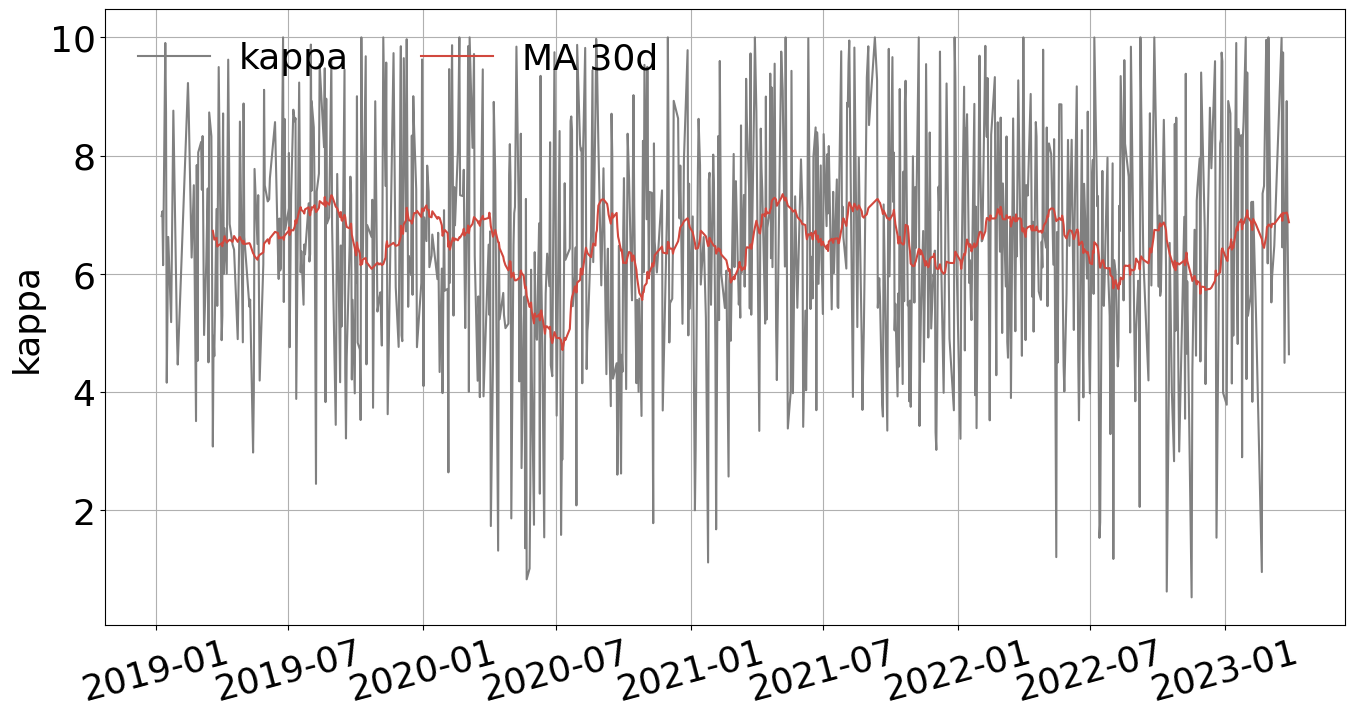

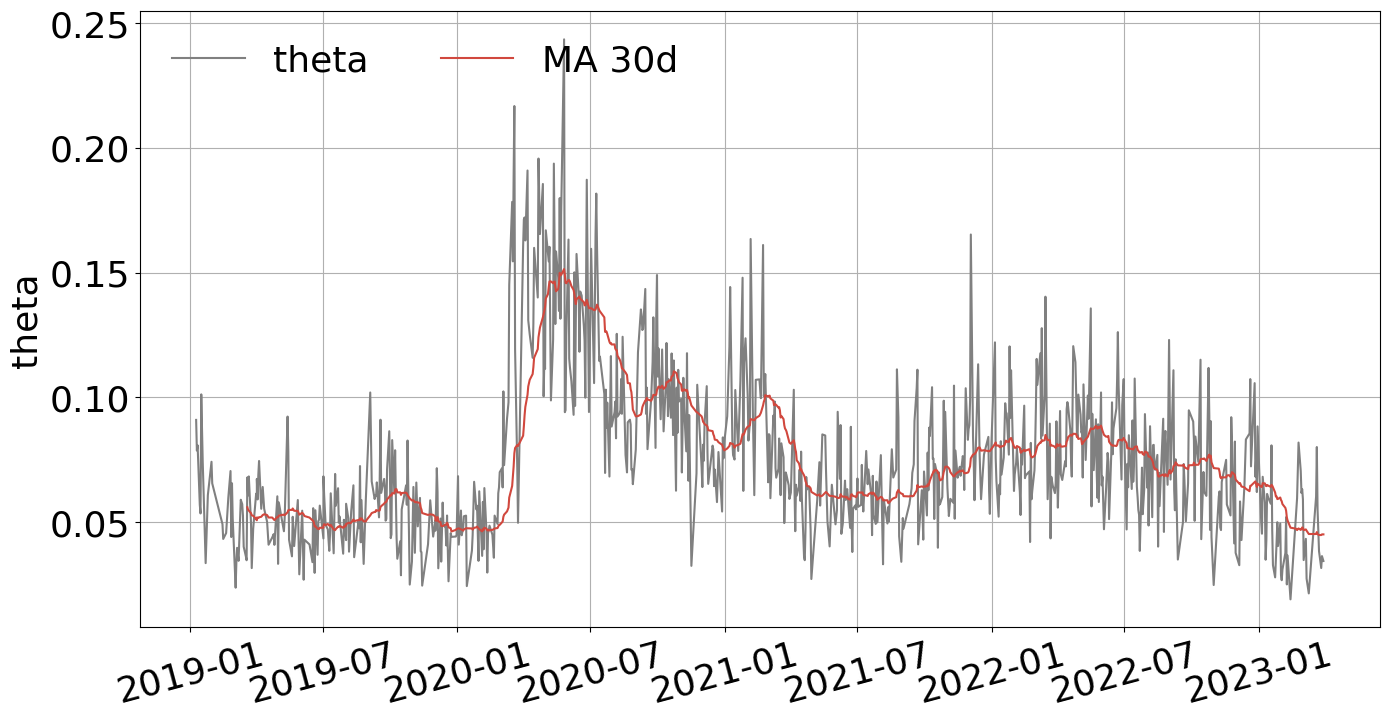

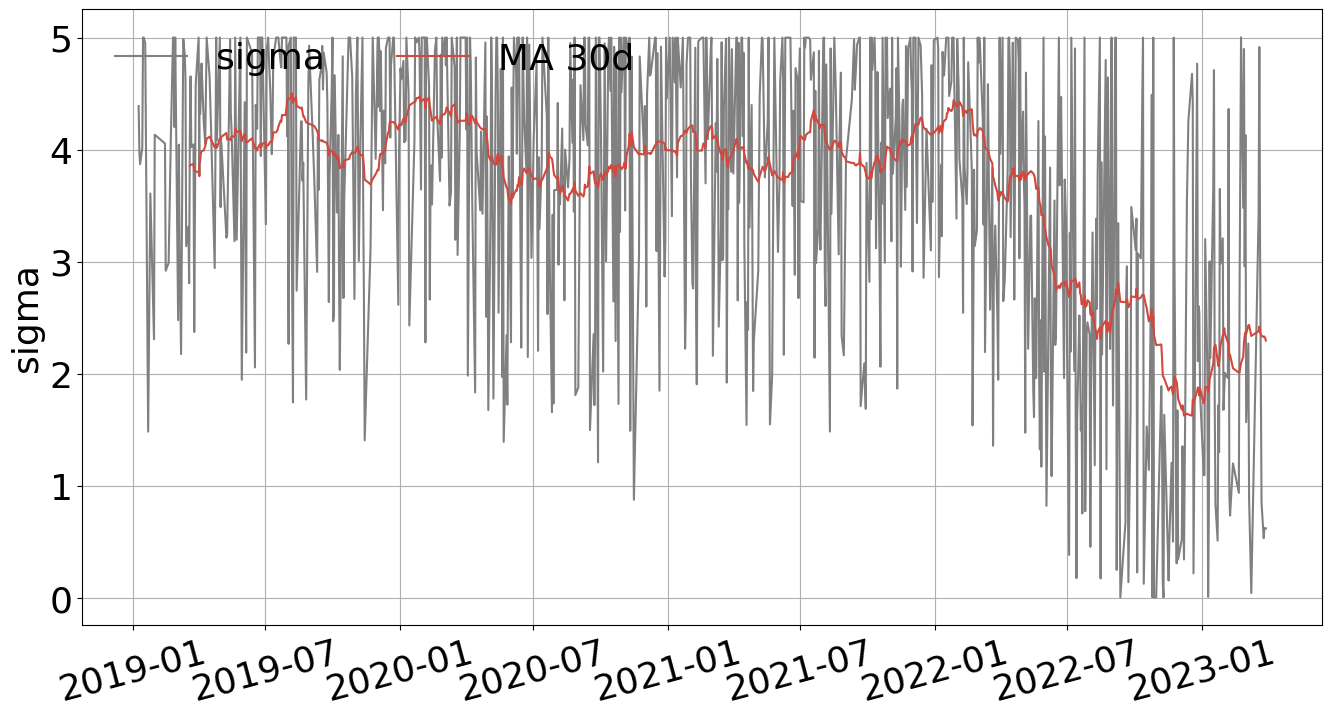

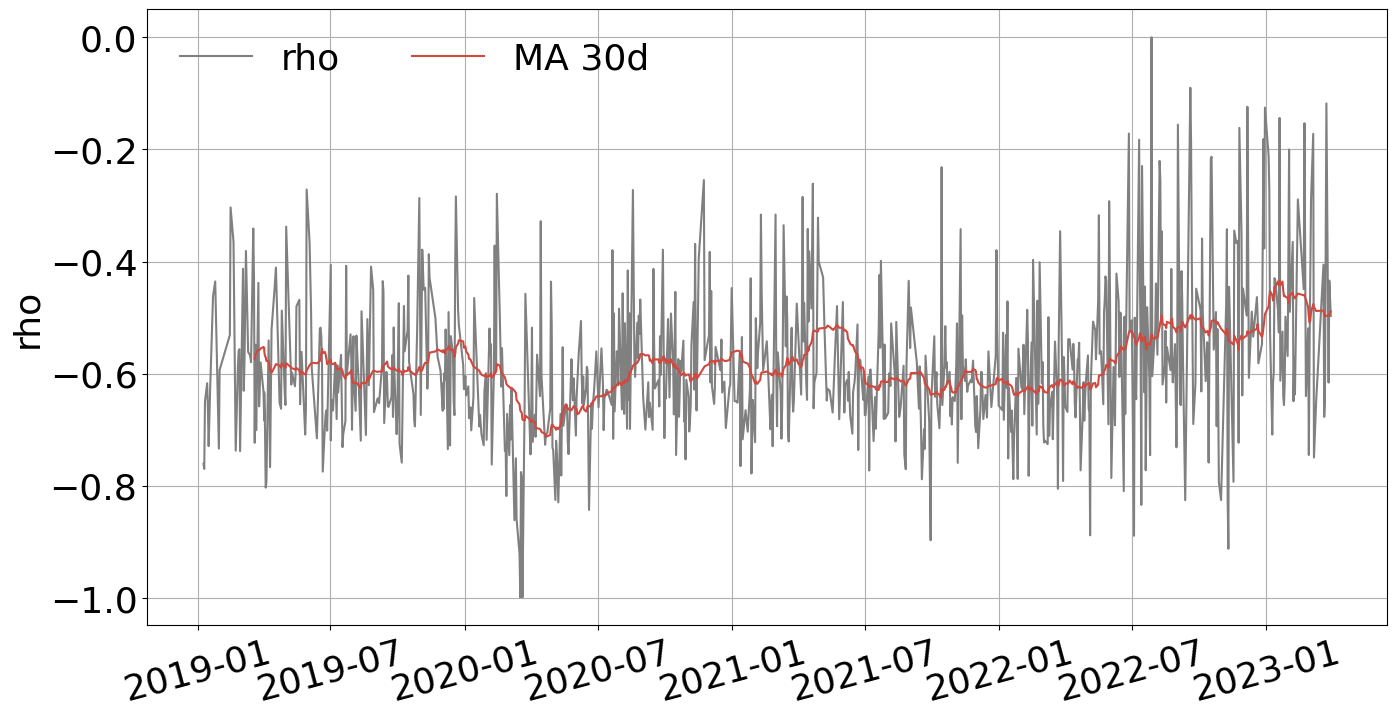

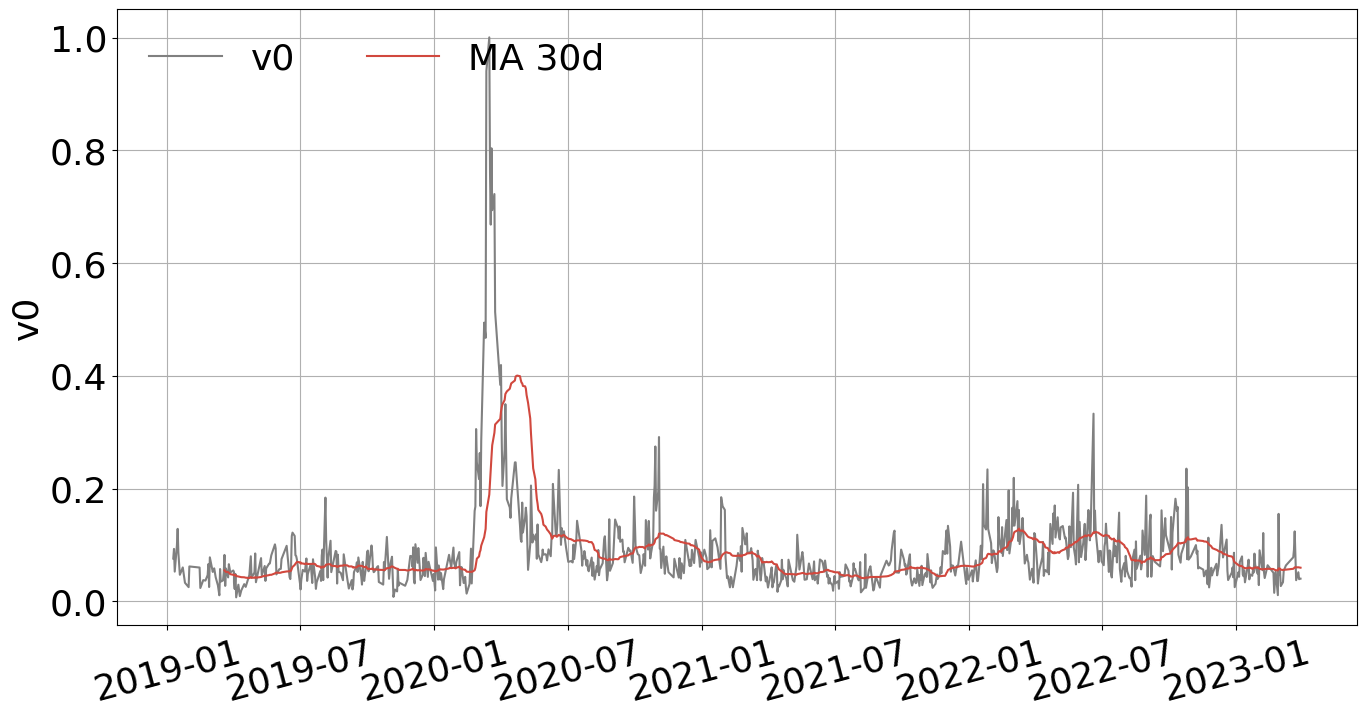

In [842]:
#in each heston parameter plot add the rfr and plot in grey and red, secondary axis for rfr, legend position topright

plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['kappa'], color='grey')
plt.plot(df['date'], df['kappa_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['kappa','MA 30d'], loc="upper left", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('kappa', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()
############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['theta'], color='grey')
plt.plot(df['date'], df['theta_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['theta','MA 30d'], loc="upper left", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('theta', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()
############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['sigma'], color='grey')
plt.plot(df['date'], df['sigma_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['sigma','MA 30d'], loc="upper left", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('sigma', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()
############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['rho'], color='grey')
plt.plot(df['date'], df['rho_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['rho','MA 30d'], loc="upper left", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('rho', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()
############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['v0'], color='grey')
plt.plot(df['date'], df['v0_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['v0','MA 30d'], loc="upper left", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('v0', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()




In [ ]:
df['rmedian_se'] = np.sqrt(df['median_se'])

In [845]:
print("rmse: ", np.mean(df['rmse']))
print("mse: ", np.mean(df['mse']))
print("mae: ", np.mean(df['mae']))
print("root median_se: ", np.mean(df['rmedian_se']))

rmse:  0.05904890835050173
mse:  0.003620288154705161
mae:  0.033050259710255665
root median_se:  0.01996684308662582


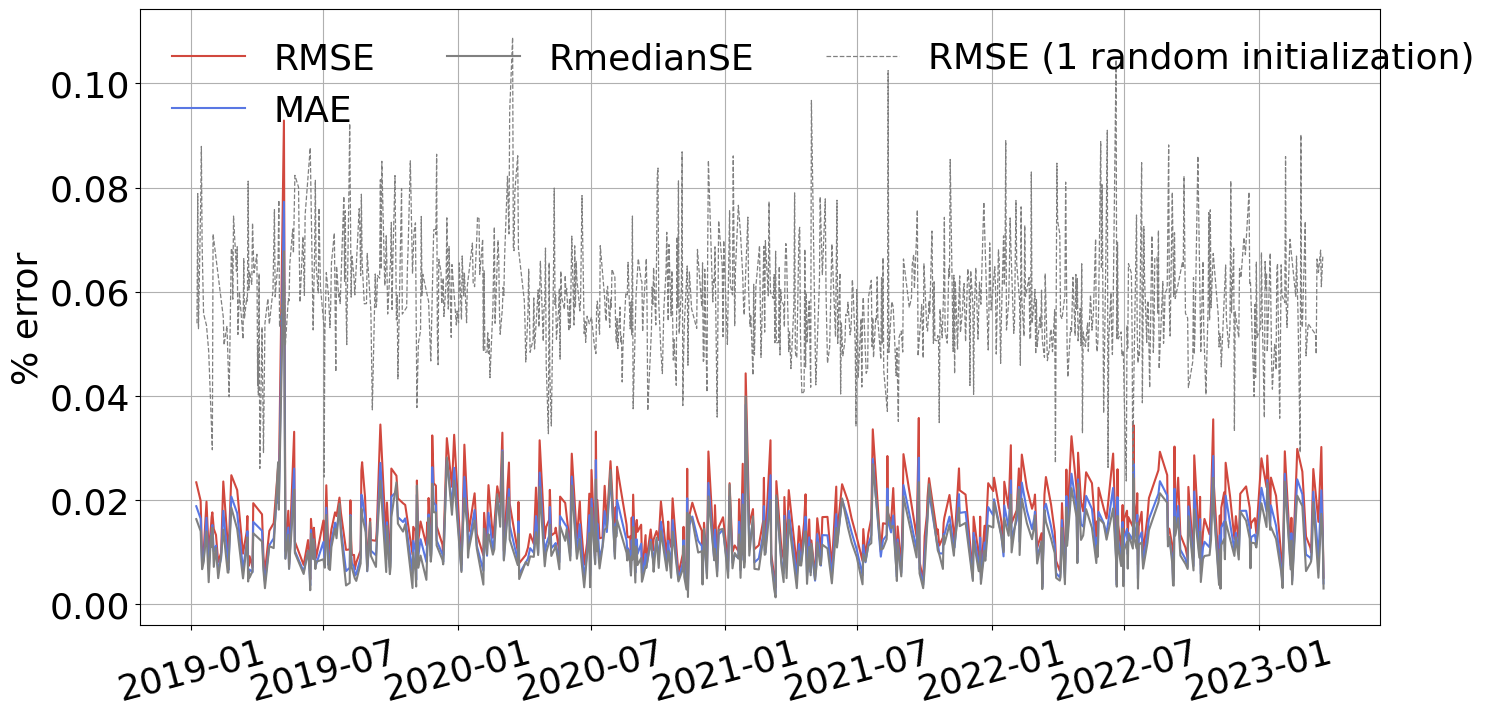

In [800]:
# Plot all lines in a single plot
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['rmse'], color='#D1483E', label='RMSE')
plt.plot(df['date'], df['mae'], color='#5977E3', label='MAE')
plt.plot(df['date'], df['rmedian_se'], color='grey', label='RmedianSE')
plt.plot(df2['date'], df2['rmse'], color='grey', label='RMSE (1 random initialization)', linestyle='dashed', linewidth=0.9)

plt.grid(True)

# Set y-axis label and percentage formatting
plt.ylabel('% error', fontsize=26)
#add second axis with same scale

# Rename and show the legend
plt.legend(loc='upper left', fontsize=26, frameon=False, ncol=3)
#tick size
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)


plt.show()

In [ ]:
df

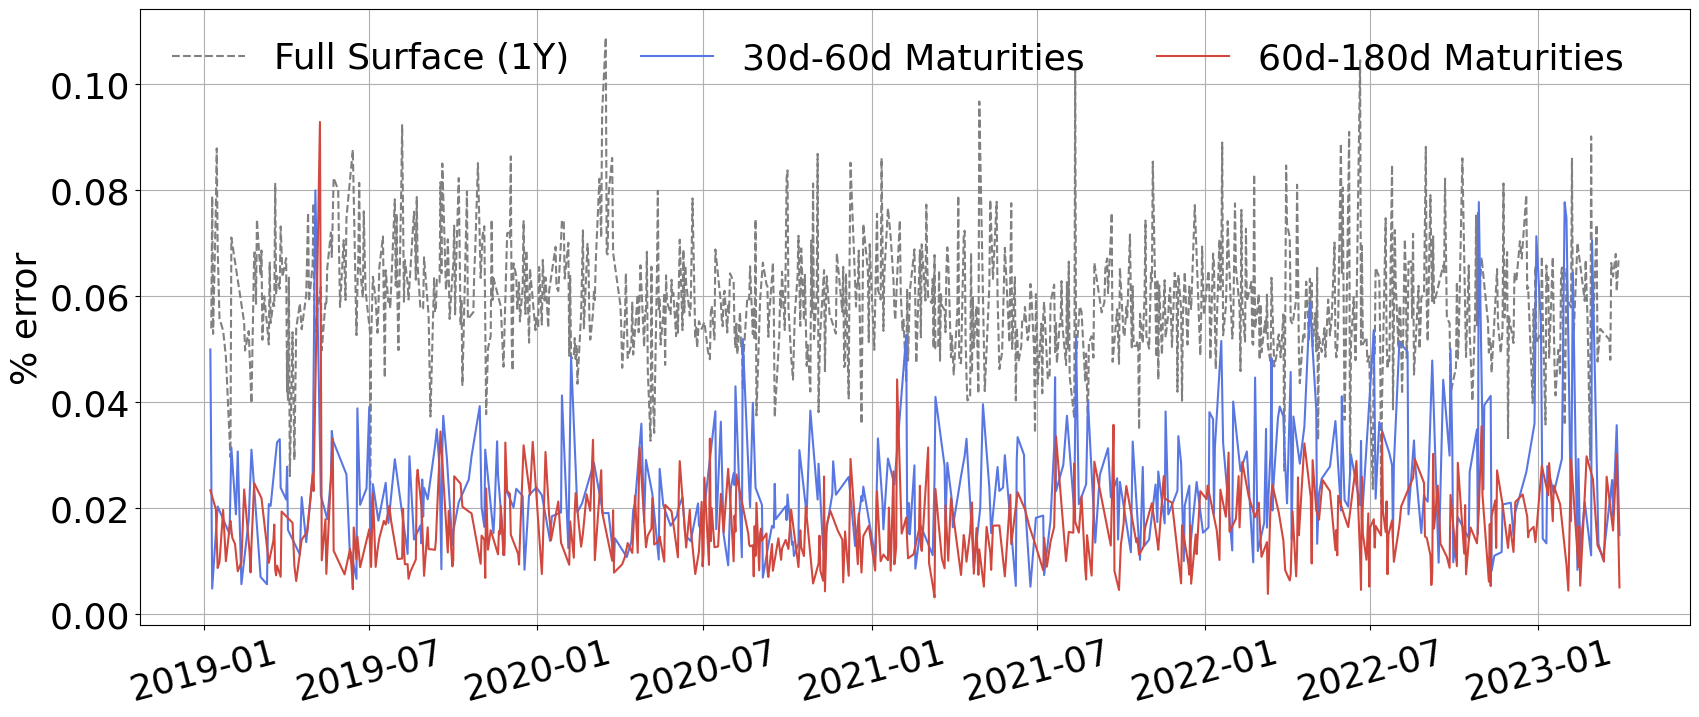

In [783]:
# Plot all lines in a single plot
plt.figure(figsize=(20, 8))
plt.plot(dfall['date'], dfall['rmse'], color='grey', label='Full Surface (1Y)', linestyle='dashed')
plt.plot(df2M['date'], df2M['rmse'], color='#5977E3', label='30d-60d Maturities')
plt.plot(df3_6M['date'], df3_6M['rmse'], color='#D1483E', label='60d-180d Maturities')

plt.grid(True)

# Set y-axis label and percentage formatting
plt.ylabel('% error', fontsize=26)
#add second axis with same scale

# Rename and show the legend
plt.legend(loc='upper left', fontsize=26, frameon=False, ncol=3)
#tick size
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)


plt.show()

<b>Stationary Calibration Results</b>

In [917]:
#load all files from
subfolder_path = os.path.join(os.getcwd(), "HestonFiles_iterations")
files = os.listdir(subfolder_path)
files = [f for f in files if f.endswith('.csv')]
#load files to csv
df = pd.DataFrame()
for f in files:
    df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
allresults = df.copy()
df.head()

C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\220132395.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\220132395.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\220132395.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_14752\220132395.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.appen

date     kappa     theta     sigma       rho        v0      rmse  \
0 2019-01-02  4.074823  0.048208  1.649422 -0.444620  0.030397  0.033915   
0 2019-01-02  2.881766  0.142571  4.296195 -0.640038  0.077466  0.063013   
1 2019-01-03  4.470450  0.104847  4.114565 -0.688772  0.126927  0.070270   
2 2019-01-04  4.425769  0.118858  4.999861 -0.671216  0.089675  0.066739   
3 2019-01-07  4.413689  0.107395  4.999861 -0.610699  0.084895  0.065265   

        mse       mae       mre  median_se  
0  0.001150  0.022973  0.138636   0.000377  
0  0.003971  0.036402  0.150484   0.000487  
1  0.004938  0.036469  0.127545   0.000360  
2  0.004454  0.037363  0.151404   0.000485  
3  0.004260  0.038420  0.162781   0.000520

In [918]:
# #filter all values where rmse is 50% above 30 days moving rmse
df = df[df['rmse'] < 4*df['rmse'].rolling(5).min()]

# df = df[df['theta'] < 3.5* df['theta'].rolling(5).min()]
# df = df[df['theta'] < 3* df['rho'].rolling(5).min()]

# df = df[df['rho'] > 3* df['rho'].rolling(30).median()]

# df = df[df['kappa'] < 4* df['kappa'].rolling(30).mean()]
df = df[df['rho'] > -1]

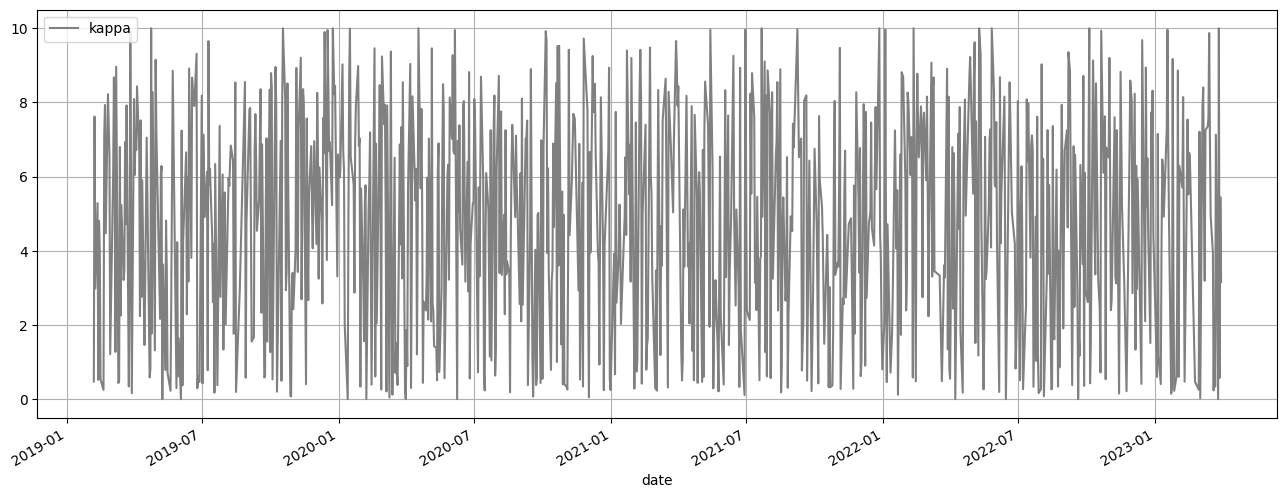

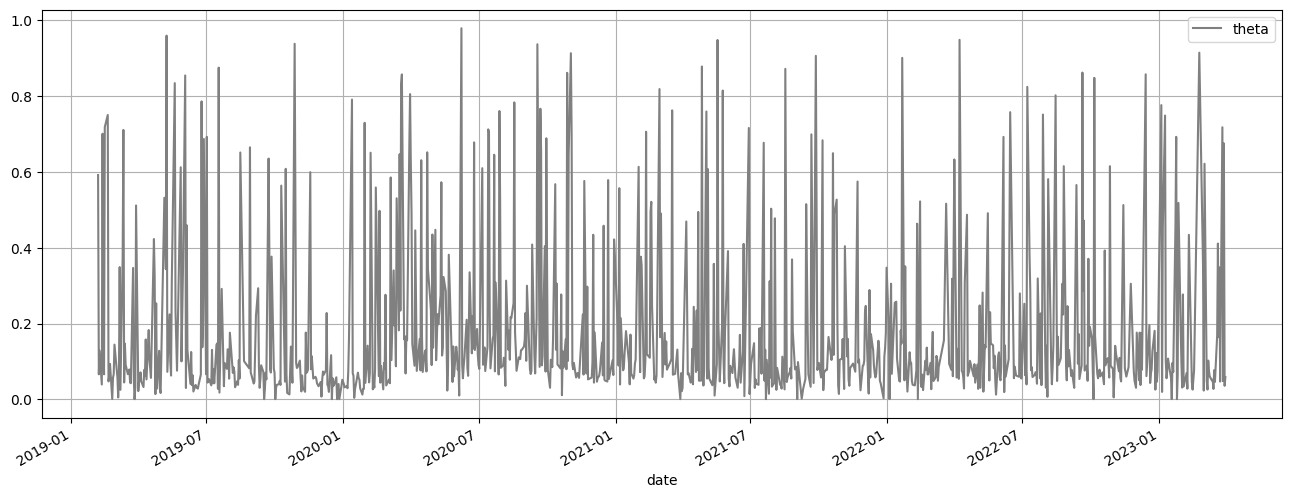

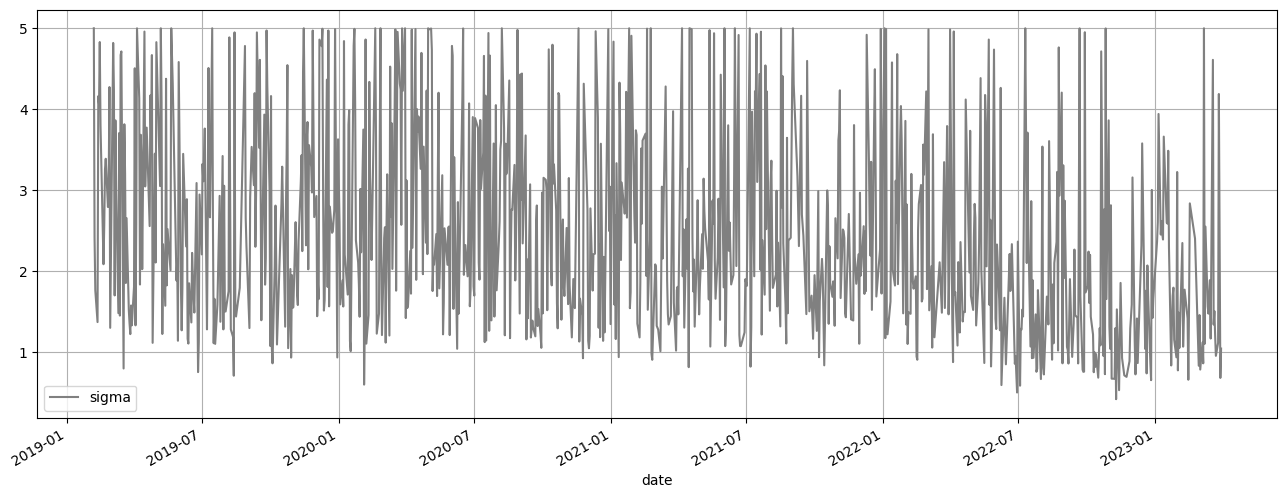

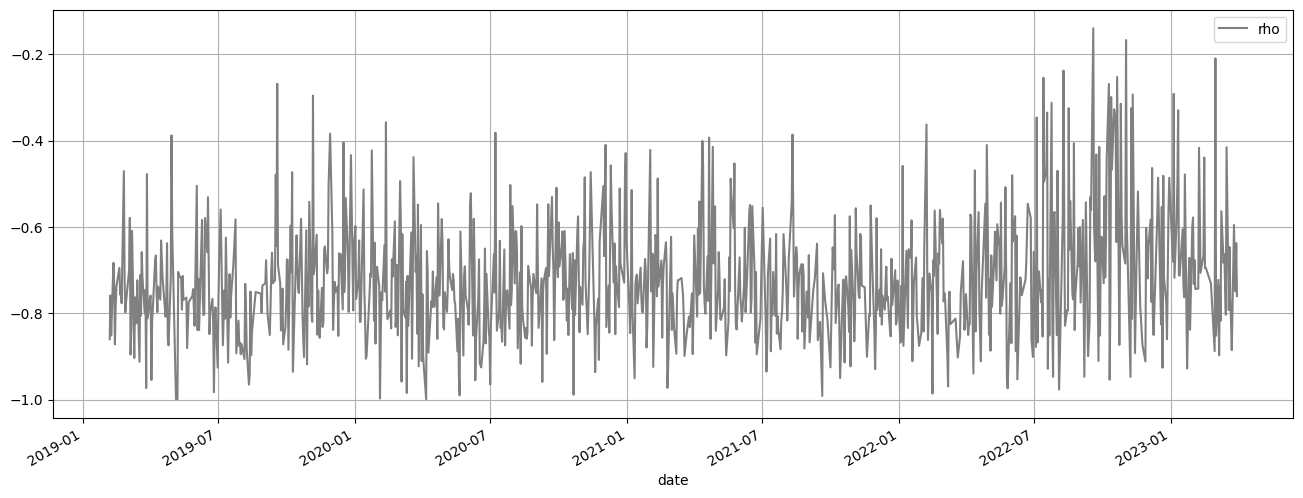

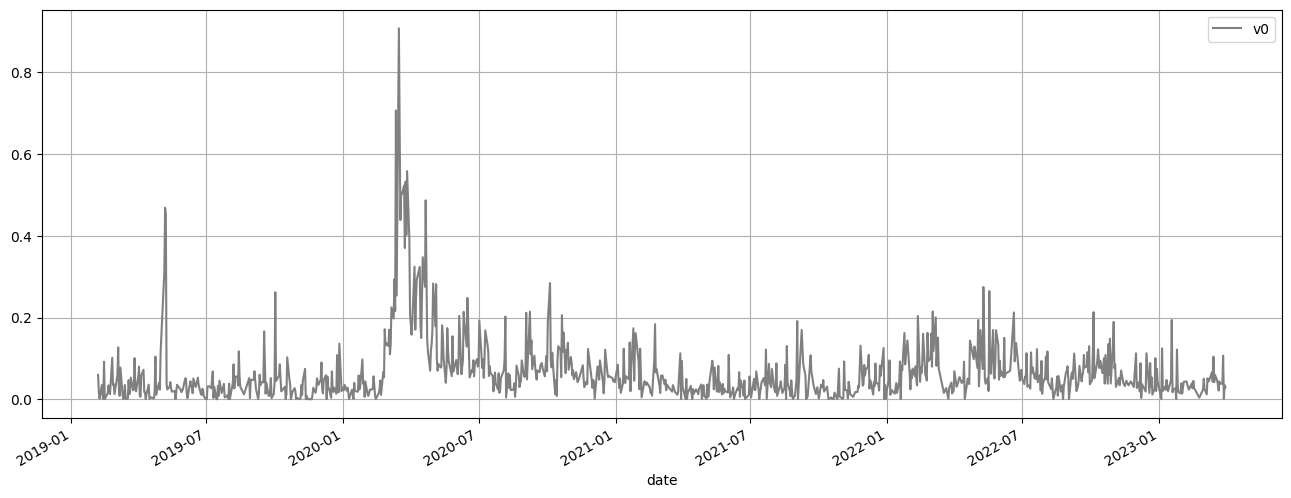

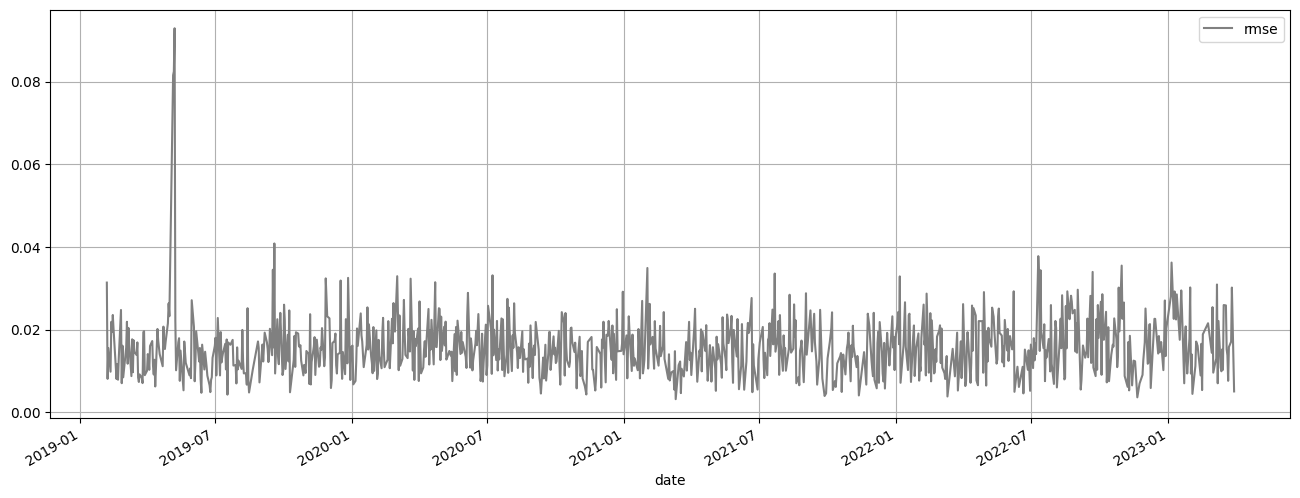

In [505]:
#plot the history of all 5 parameters
df.plot(x='date', y=['kappa'], figsize=(16, 6), grid=True, color = 'grey')
df.plot(x='date', y=['theta'], figsize=(16, 6), grid=True, color = 'grey')
df.plot(x='date', y=['sigma'], figsize=(16, 6), grid=True, color = 'grey')
df.plot(x='date', y=['rho'], figsize=(16, 6), grid=True, color = 'grey')
df.plot(x='date', y=['v0'], figsize=(16, 6), grid=True, color = 'grey')
df.plot(x='date', y=['rmse'], figsize=(16, 6), grid=True, color = 'grey')
plt.show()



In [461]:
df['rmedian_se'] = np.sqrt(df['median_se']).rolling(2).median()

In [462]:
print("rmse: ", np.mean(df['rmse']))
print("mse: ", np.mean(df['mse']))
print("mae: ", np.mean(df['mae']))
print("root median_se: ", np.mean(df['rmedian_se']))

rmse:  0.016678063807108096
mse:  0.000348757153063559
mae:  0.013510813961155013
root median_se:  0.012010636101732025


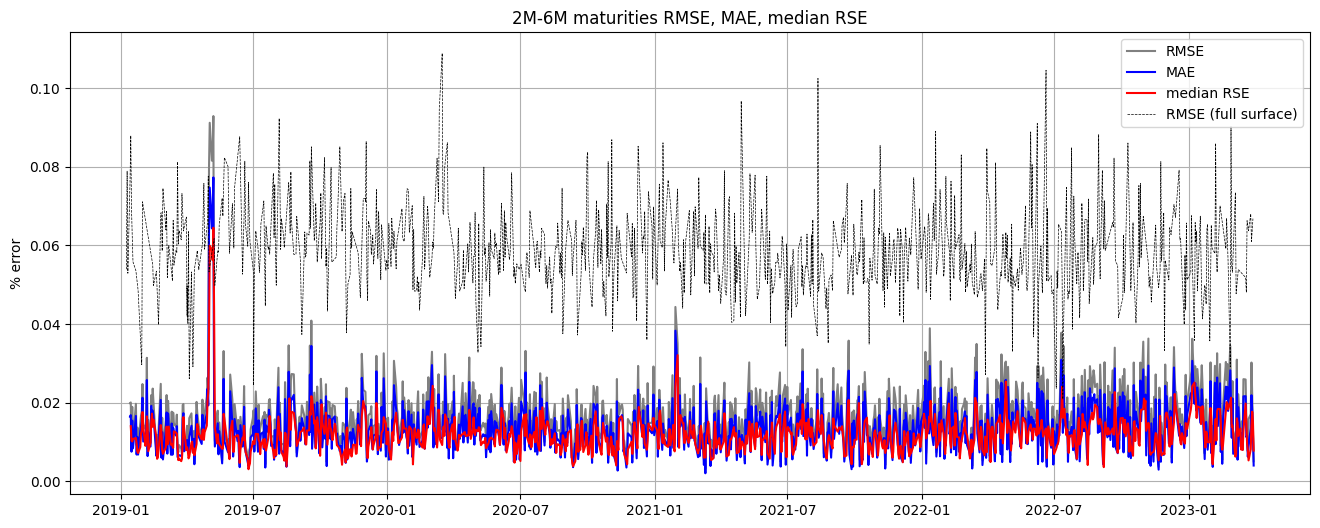

In [464]:
# Plot all lines in a single plot
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['rmse'], color='grey', label='RMSE')
plt.plot(df['date'], df['mae'], color='blue', label='MAE')
plt.plot(df['date'], df['rmedian_se'], color='red', label='median RSE')
plt.plot(df2['date'], df2['rmse'], color='black', linestyle='dashed', label='RMSE (full surface)', linewidth=0.5)

# Set title and grid
plt.title('2M-6M maturities RMSE, MAE, median RSE')
plt.grid(True)

# Set y-axis label and percentage formatting
plt.ylabel('% error')


# Rename and show the legend
plt.legend()

# Show the plot
plt.show()


<b>30 days standard deviation</b>

In [919]:
#for each param calc 30 days rolling sd
df['kappa_sd'] = df['kappa'].rolling(30).std()
df['theta_sd'] = df['theta'].rolling(30).std()
df['sigma_sd'] = df['sigma'].rolling(30).std()
df['rho_sd'] = df['rho'].rolling(30).std()
df['v0_sd'] = df['v0'].rolling(30).std()
df['rmse_sd'] = df['rmse'].rolling(30).std()

In [920]:
#standardize sd with CV
df['kappa_sd'] = df['kappa_sd'] / df['kappa'].rolling(30).mean()
df['theta_sd'] = df['theta_sd'] / df['theta'].rolling(30).mean()
df['sigma_sd'] = df['sigma_sd'] / df['sigma'].rolling(30).mean()
df['rho_sd'] = df['rho_sd'] / df['rho'].rolling(30).mean()
df['v0_sd'] = df['v0_sd'] / df['v0'].rolling(30).mean()
df['rmse_sd'] = df['rmse_sd'] / df['rmse'].rolling(30).mean()

In [921]:
#flip sign of rho sd
df['rho_sd'] = -df['rho_sd']

In [922]:
#rename from sd to cv
df = df.rename(columns={'kappa_sd': 'kappa_cv', 'theta_sd': 'theta_cv', 'sigma_sd': 'sigma_cv', 'rho_sd': 'rho_cv', 'v0_sd': 'v0_cv', 'rmse_sd': 'rmse_cv'})

In [933]:
df['theta_cv'] = df['theta_cv']*1.5

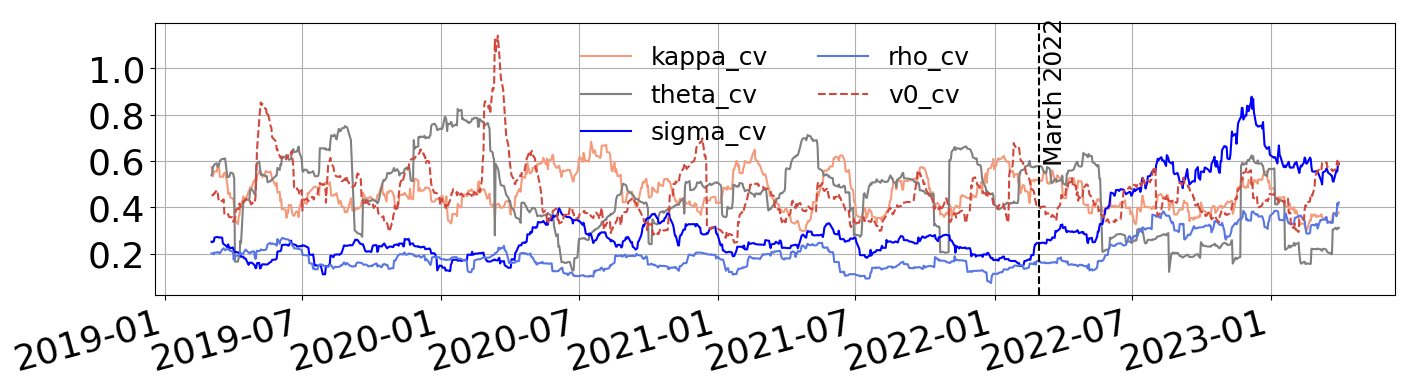

In [934]:
df.plot(x='date', y=['kappa_cv', 'theta_cv', 'sigma_cv', 'rho_cv', 'v0_cv'],
        figsize=(16, 4), grid=True,
        color=('#F49B7C', 'grey', 'blue', '#5977E3', '#D1483E'),
        style=['-', '-', '-', '-', '--'])
#legend size
plt.legend(fontsize=18,ncols = 2, frameon=False, loc='upper center')
plt.axvline('2022-02-28', color='black', linestyle='dashed')
plt.text('2022-03-06', 0.6, 'March 2022 ', rotation=90, fontsize=18)
#tick size
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
#delete x axis title
plt.xlabel('')

plt.show()


<b>Stationary Heston Model Calibration</b> <br><br>
<i>we adjust the grid and make it more granular with regards to maturities and reduce the number of days to maturity to a smaller interval </i>

In [527]:
year = 2019
for i in range(1,2):
    month = i
    df1 = helpers.load_month(year, month,'SPX')
    df1,len = helpers.split_days(df1, num_groups = 1)

    #store the results in a df
    results = pd.DataFrame(columns=['date', 'kappa', 'theta', 'sigma', 'rho', 'v0', 'rmse', 'mse', 'mae', 'mre', 'median_se'])


    subfolder_path = os.path.join(os.getcwd(), "StationaryHeston3M-6M")

    dates, percent = helpers.init()

    for zz in range(1):

        df2 = df1[zz]
        
        

        #only use traded quotes, this is already done in the pre-processing and just to be sure no illiquid quotes are left over
        #df = df[df[' [C_VOLUME]'] > 0]
        df2 = df2[df2[' [C_VOLUME]'] != " "]
        df2 = df2[df2[' [C_VOLUME]'] != ""]


        daysaddasint = np.array(helpers.get_daystomaturity(df2)).astype(int)
        strikes = np.array(helpers.get_strike(df2))
        implied_vols = np.array(helpers.get_IV_C(df2))
        year, month, day = helpers.get_pricingdate(df2)
        
        #convert to date
        date = datetime.date(year, month, day)

        spot = helpers.get_underlyinglast(df2)
            
        mean_vola = np.mean(implied_vols)

        down = 0.835
        up = 1.169

        filter1 = strikes > down*spot
        filter2 = strikes < up*spot
        filter3 = daysaddasint > 0
        filter4 = daysaddasint <= 30


        filter = filter1 & filter2 & filter3 & filter4

        implied_vols = implied_vols[filter].flatten()
        strikes = strikes[filter].flatten()/spot
        daysaddasint = daysaddasint[filter].astype(int).flatten()/365.0



        #add some buckets to the grid which we will use later
        adddays = np.repeat(np.mean(daysaddasint), 10)#np.linspace(0.01,1,6)
        #short_end = np.array([0.01, 0.02, 0.03, 0.04]).flatten()    #they should be contained in the grid
        daysaddasint = np.concatenate((daysaddasint, adddays))#/0.005)*0.005 #np.concatenate((np.round(np.concatenate((daysaddasint, adddays))/0.005)*0.005,short_end))
        #
        strikesadd = np.round(np.linspace(0.85,1.15,9),2)
        strikes = np.round(np.concatenate((strikes, strikesadd))/0.03)*0.03
        atm = np.array(1.0).flatten()

        strikes = np.concatenate((strikes,atm))#at the money is out of rounding scheme
        #16x np.nan
        nans = np.repeat(np.nan, 10)
        implied_vols = np.concatenate((implied_vols, nans))


        daysaddasint_unique = sorted(np.unique(daysaddasint))

        consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})

        #use mean in case of dublicates
        consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


        # Pivot the dataframe to create the matrix
        volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')

        #interpolation is used to find outliers, therefore a much denser grid is needed, the interpolated values are not used for calibration
        try:
            volmatrix_interpolation = volmatrix.interpolate(method='quadratic')
        except:
            print("Interpolation failed")
            volmatrix_interpolation = volmatrix.copy()

        #remove negative values after interpolation
        volmatrix_interpolation[volmatrix_interpolation < 0] = np.nan

        # outlier detection, one iteration already gives good results 
        # we iterate over smiles and check each smile for outliers
        for i, ds in enumerate(np.array(daysaddasint_unique)):
            first_col = volmatrix_interpolation.iloc[:, i]
            y = first_col.values
            # Smooth the data using a Savitzky-Golay filter
            
            # Calculate the absolute difference between y and y_smooth, more than 2% difference is considered an outlier
            diff = np.abs(y - savgol_filter(y, 6, 1, mode='interp'))> 0.02

            #now we remove the outliers from the original matrix
            #without the interpolation, the outlier detection is not as good
            volmatrix.iloc[diff, i] = np.nan
            volmatrix_interpolation.iloc[diff, i] = np.nan

            
        dates_unique = sorted(np.unique(volmatrix.columns))

        strikes_unique = sorted(volmatrix.index.astype(float))

        #convert volmatrix back to df with 3 cols
        #datf = volmatrix.stack().reset_index()
        #mame cols
        #datf.columns = ['Strike', 'Time to Maturity', 'iv']
        try:
            a = volmatrix.interpolate(method='quadratic', axis=0)
        except:
            print("Interpolation failed")
            a = volmatrix.copy()
        try:    
            b = a.interpolate(method='quadratic', axis=1)
            b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)
        except:
            print("Interpolation failed")
            b = a.copy()


        datf = b.stack().reset_index()
        datf.columns = ['Moneyness', 'Time to Maturity', 'iv']

        rmse_best = 10000000.0
        
        for i in range(0,4):
            initial_params = model_parameters_initializer('heston')[0]
            # parameters have to be scaled into the NN dimensions in order not to be out of bounds during initialization, done later
            #test given the sample generated above to test the NN
            data = pd.DataFrame()
            data['Moneyness'] = datf['Moneyness'].values
            data['Time to Maturity (years)'] = datf['Time to Maturity'].values
            #dummy to rescale, not used
            data['kappa'] = initial_params[0]
            data['theta'] = initial_params[1]
            data['sigma'] = initial_params[2]
            data['rho'] = initial_params[3]
            data['v0'] = initial_params[4]

            datascaled = SCALER.transform(data)
            moneyness = datascaled.iloc[:, 0].values
            time_to_maturity = datascaled.iloc[:, 1].values
            initial_params = datascaled.iloc[0, 2:].values      #initial guess is rescaled to the NN feature space
            #calibrate to reach this vola
            actual_vola = datf['iv'].values                    #we try to retrieve the parameters we used to generate the surface in df


            result_manual, rmse, mse, mae, mre, median_se = manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75)

            if rmse.iloc[0] < rmse_best:

                #convert the optimal parameters back to the original space
                data = pd.DataFrame()
                data['Moneyness'] = [1.0]
                data['Time to Maturity (years)'] = [1.0]
                data['kappa'] = result_manual[0]
                data['theta'] = result_manual[1]
                data['sigma'] = result_manual[2]
                data['rho'] = result_manual[3]
                data['v0'] = result_manual[4]
                rmse_best = rmse.iloc[0]


                data = SCALER.inverse_transform(data)
                #split the result into the df
                results.loc[zz] = [date, data.iloc[0, 2], data.iloc[0, 3], data.iloc[0, 4], data.iloc[0, 5], data.iloc[0, 6], rmse, mse, mae, mre, median_se]

    results['rmse'] = results['rmse'].astype(float)
    results['mse'] = results['mse'].astype(float)
    results['mae'] = results['mae'].astype(float)
    results['mre'] = results['mre'].astype(float)
    results['median_se'] = results['median_se'].astype(float)

    #save the results and include the month and year in the filename
    file_path = os.path.join(subfolder_path, "Stationary_Heston_calibration_60to180days{}.csv".format(str(year)+str(month)))
    #results.to_csv(file_path, index=False)

7/7 [==============================] - 0s 3ms/step
Iteration: 0, Loss: 42.62038538865079
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 7.332042982915574
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 2.4
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 7.034514995351332
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 7.004884315742219
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 38.4
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 6.998654360931509
7/7 [==============================] - 0s 1ms/step
Learning rate increased to 153.6
7/7 [===========

c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()

7/7 [==============================] - 0s 2ms/step
Iteration: 0, Loss: 64.13193369901144
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 6.923592710223275
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 2.4
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 6.609751520814914
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 6.566565064590587
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 38.4
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 6.555804734070548
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 153.6
7/7 [===========

c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()

7/7 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 7.271762645061087
7/7 [==============================] - 0s 5ms/step
Learning rate increased to 2.4
7/7 [==============================] - 0s 5ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 6.614730888509326
7/7 [==============================] - 0s 6ms/step
Learning rate increased to 9.6
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 6.524784089324147
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 38.4
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 6.507161268886813
7/7 [==============================] - 0s 1ms/step
Learning rate increased to 153.6
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 307.2
Iteration: 10, Loss: 

c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()

7/7 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 5.498903314565199
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 2.4
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 5.565305252708135
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 9.6
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 5.532069258325083
7/7 [==============================] - 0s 4ms/step
Learning rate increased to 38.4
7/7 [==============================] - 0s 4ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 5.519290624954682
7/7 [==============================] - 0s 4ms/step
Learning rate increased to 153.6
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 307.2
Iteration: 10, Loss: 

c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\caspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()

In [528]:
#get last row of results
lastrow = results.iloc[-1, :]
lastrow

date         2019-01-02
kappa           3.97728
theta          0.000407
sigma          2.730316
rho           -0.658056
v0             0.069413
rmse           0.045077
mse            0.002032
mae            0.028576
mre            0.101006
median_se      0.000434
Name: 0, dtype: object

In [529]:
from utils import *

In [530]:
data = pd.DataFrame()
data['Moneyness'] = datf['Moneyness'].values
data['Time to Maturity (years)'] = datf['Time to Maturity'].values
data['iv'] = datf['iv'].values
data['Log Moneyness'] = np.log(data['Moneyness'])
kappa, theta, sigma, rho, v0 = lastrow[1:6].values
hestonvola = data.progress_apply(lambda row: heston_pricer(kappa, theta, sigma, rho, v0,0,0, row['Time to Maturity (years)'], 1.0, row['Moneyness'])[1], axis=1)


100%|██████████| 193/193 [00:01<00:00, 101.68it/s]


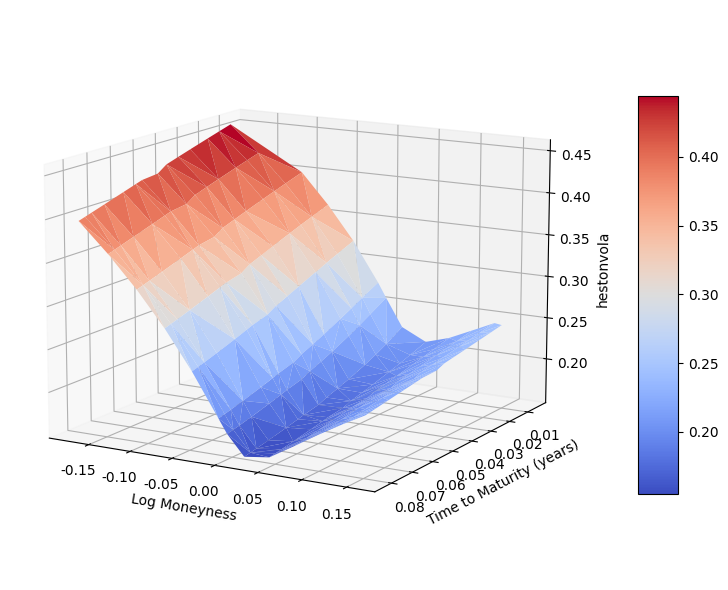

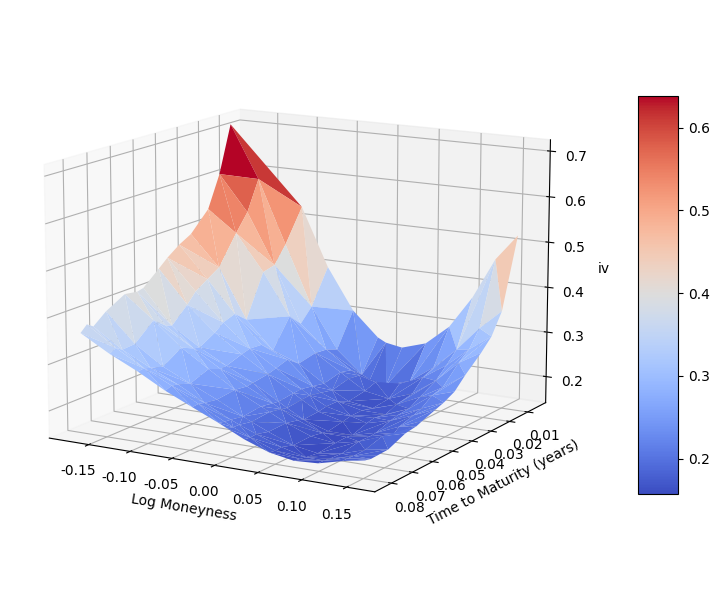

In [531]:
data['hestonvola'] = hestonvola
plot_iv_surface(data, z='hestonvola')
plot_iv_surface(data, z='iv')

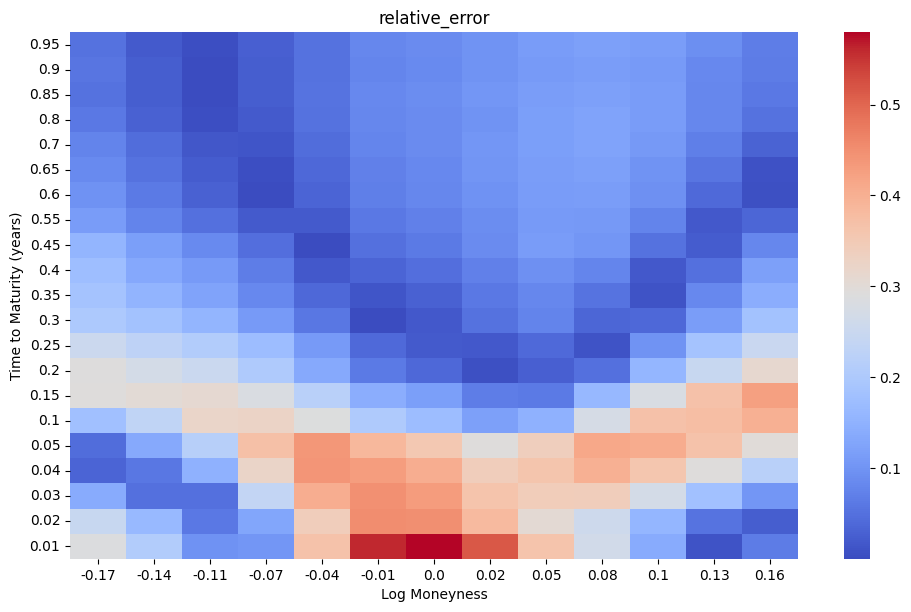

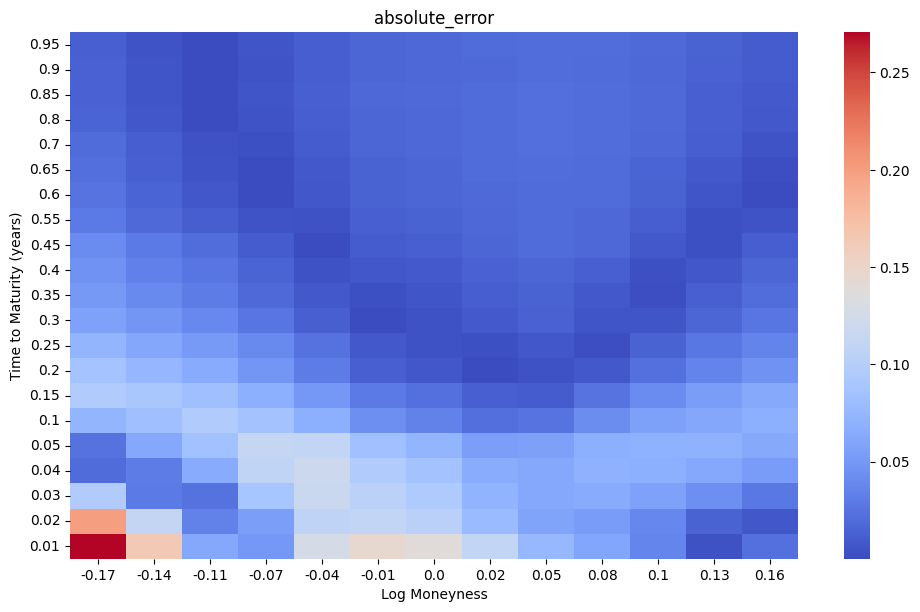

In [31]:
#relative and absolute error
data['relative_error'] = np.abs(data['hestonvola'] - data['iv']) / data['iv']
data['absolute_error'] = np.abs(data['hestonvola'] - data['iv'])
plot_heatmap(data, 'relative_error')
plot_heatmap(data, 'absolute_error')


<b>Visualization of Error Heatmap dense grid</b>

In [535]:
alldays = pd.read_csv("alldaysconcat.csv")

In [536]:
alldays['date'] = pd.to_datetime(alldays['date'])
merged_df = alldays.merge(allresults, on='date', how='left')

In [537]:
#save mergeddf to csv
merged_df.to_csv("hestonconcatenatedresultsforerror.csv", index=False)
merged_df.head()

KeyboardInterrupt: 

In [607]:
predicting = pd.DataFrame()
predicting['Moneyness'] = merged_df['Moneyness']
predicting['Time to Maturity (years)'] = merged_df['Time to Maturity']
predicting['kappa'] = merged_df['kappa']
predicting['theta'] = merged_df['theta']
predicting['sigma'] = merged_df['sigma']
predicting['rho'] = merged_df['rho']
predicting['v0'] = merged_df['v0']
scaled = SCALER.transform(predicting)
predicting['predicted_iv'] = model.predict(scaled)
predicting['absolute_error'] = np.abs(predicting['predicted_iv'] - merged_df['iv'])
predicting['relative_error'] = np.abs(predicting['predicted_iv'] - merged_df['iv'])/merged_df['iv']

8344/8344 [==============================] - 29s 4ms/step


In [622]:
#pivot with rows moneyness cols time to maturity and values rmse aggregated by mean
flatteneddf = predicting.pivot_table(index='Moneyness', columns='Time to Maturity (years)', values='absolute_error', aggfunc='mean').stack().reset_index()

In [623]:
#name cols
flatteneddf.columns = ['Moneyness', 'Time to Maturity (years)', 'absolute_error']
flatteneddf['Log Moneyness'] = np.log(flatteneddf['Moneyness'])
flatteneddf.head()

Moneyness  Time to Maturity (years)  absolute_error  Log Moneyness
0       0.84                      0.01        0.120353      -0.174353
1       0.84                      0.02        0.070622      -0.174353
2       0.84                      0.03        0.047375      -0.174353
3       0.84                      0.04        0.041501      -0.174353
4       0.84                      0.05        0.051751      -0.174353

In [620]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(data, values='re'):
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot_table(index='Time to Maturity (years)', columns='Log Moneyness', values=values, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap='coolwarm', cbar=True,
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.title(values, fontsize=22)
    plt.xlabel('Log Moneyness', fontsize=22)
    plt.ylabel('Time to Maturity (years)', fontsize=22)
    # Adjust x-axis tick labels
    plt.xticks(rotation='vertical')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=16)
    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)
    plt.show()


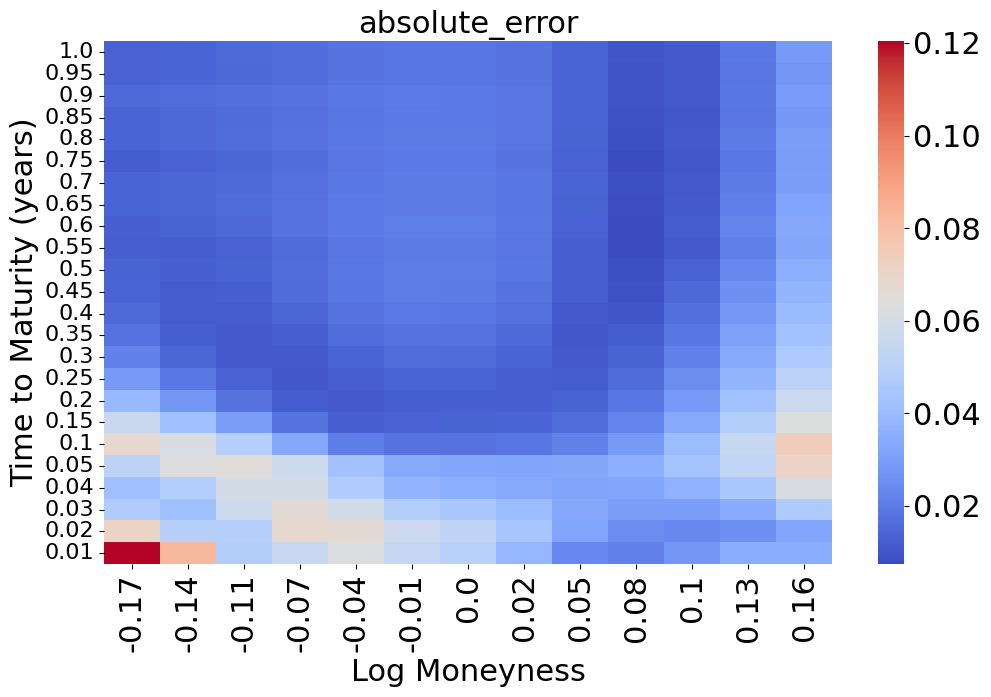

In [624]:
plot_heatmap(flatteneddf, 'absolute_error')

In [615]:
#pivot with rows moneyness cols time to maturity and values rmse aggregated by mean
flatteneddf = predicting.pivot_table(index='Moneyness', columns='Time to Maturity (years)', values='relative_error', aggfunc='mean').stack().reset_index()

In [616]:
#name cols
flatteneddf.columns = ['Moneyness', 'Time to Maturity (years)', 'relative_error']
flatteneddf['Log Moneyness'] = np.log(flatteneddf['Moneyness'])
flatteneddf.head()

Moneyness  Time to Maturity (years)  relative_error  Log Moneyness
0       0.84                      0.01        0.234332      -0.174353
1       0.84                      0.02        0.158896      -0.174353
2       0.84                      0.03        0.142149      -0.174353
3       0.84                      0.04        0.159995      -0.174353
4       0.84                      0.05        0.166568      -0.174353

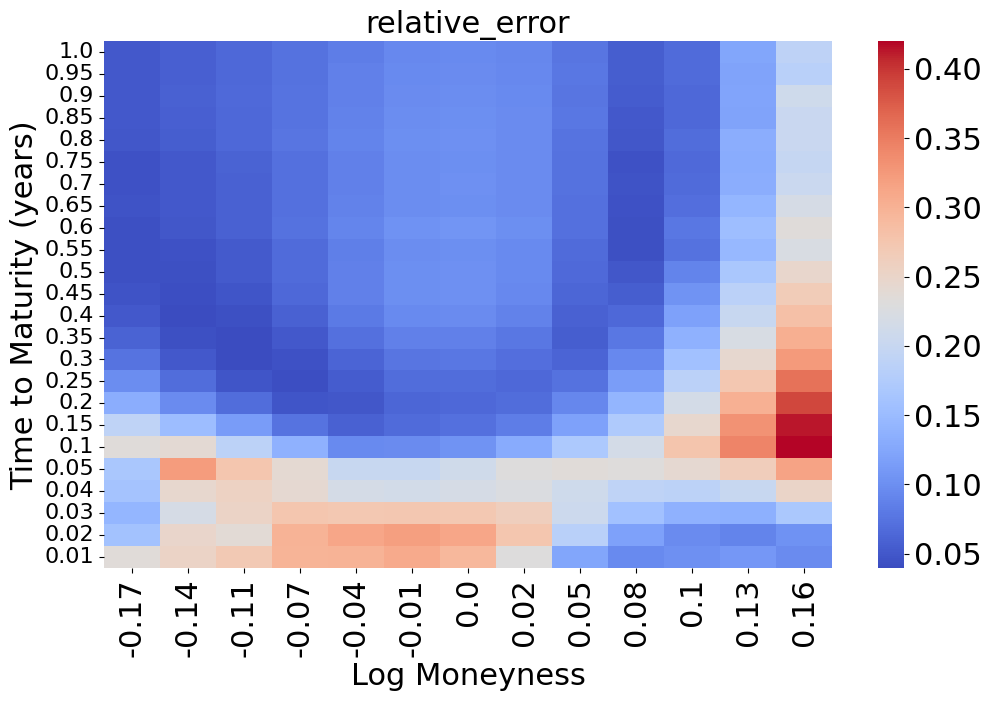

In [621]:
plot_heatmap(flatteneddf, 'relative_error')